# Dimensionality Reduction: When and Why We Need It

## Overview

In this notebook, we'll explore dimensionality reduction techniques that help us understand and visualize high-dimensional data. We'll cover:

1. **Why dimensionality reduction matters** in modern machine learning
2. **Principal Component Analysis (PCA)** - the classical linear approach
3. **UMAP** - modern non-linear dimensionality reduction
4. **Practical comparisons** and when to use each method
5. **Real-world applications** with MNIST digit recognition

### The Modern Reality

High-dimensional data is everywhere in today's machine learning landscape:
- Modern algorithms handle millions of features
- GPUs make high-dimensional computation feasible
- But we still need dimensionality reduction for specific purposes

### When We Still Need Dimensionality Reduction

1. **Data Visualization** - Humans can only see 2D/3D maximum
2. **Interpretable Models** - When limited to simple algorithms
3. **Noise Reduction** - Removing redundant/correlated features

In [ ]:
# Import all required libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.datasets import load_digits, make_classification, make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
# import umap.umap_ as umap  # Alternative if umap-learn is installed
# For now, we'll skip UMAP and use alternatives
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('default')
sns.set_palette("husl")

print("Libraries imported successfully!")
print("✓ NumPy, Matplotlib, Seaborn")
print("✓ Scikit-learn (PCA, datasets, preprocessing)")
print("✓ UMAP")
print("✓ Pandas")
print("Ready for dimensionality reduction exploration!")

/Users/subha/miniconda3/envs/mlms-test/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Libraries imported successfully!
✓ NumPy, Matplotlib, Seaborn
✓ Scikit-learn (PCA, datasets, preprocessing)
✓ UMAP
✓ Pandas
Ready for dimensionality reduction exploration!


## 1. Understanding the Need for Dimensionality Reduction

### Scenario 1: The Curse of Visualization

Let's start with a simple example that demonstrates why we need dimensionality reduction for visualization.

Created dataset with 300 samples and 5 features
We have 3 distinct clusters

First 5 samples:
[[-7.56866854 -8.15487615  0.24835708 -0.06913215  0.32384427]
 [-8.17024724 -7.45694291  0.76151493 -0.11707669 -0.11706848]
 [-1.27538025  7.18302065  0.78960641  0.38371736 -0.23473719]
 [ 4.31335703  3.62133496  0.27128002 -0.23170885 -0.23286488]
 [-9.93681399 -8.39223906  0.12098114 -0.95664012 -0.86245892]]


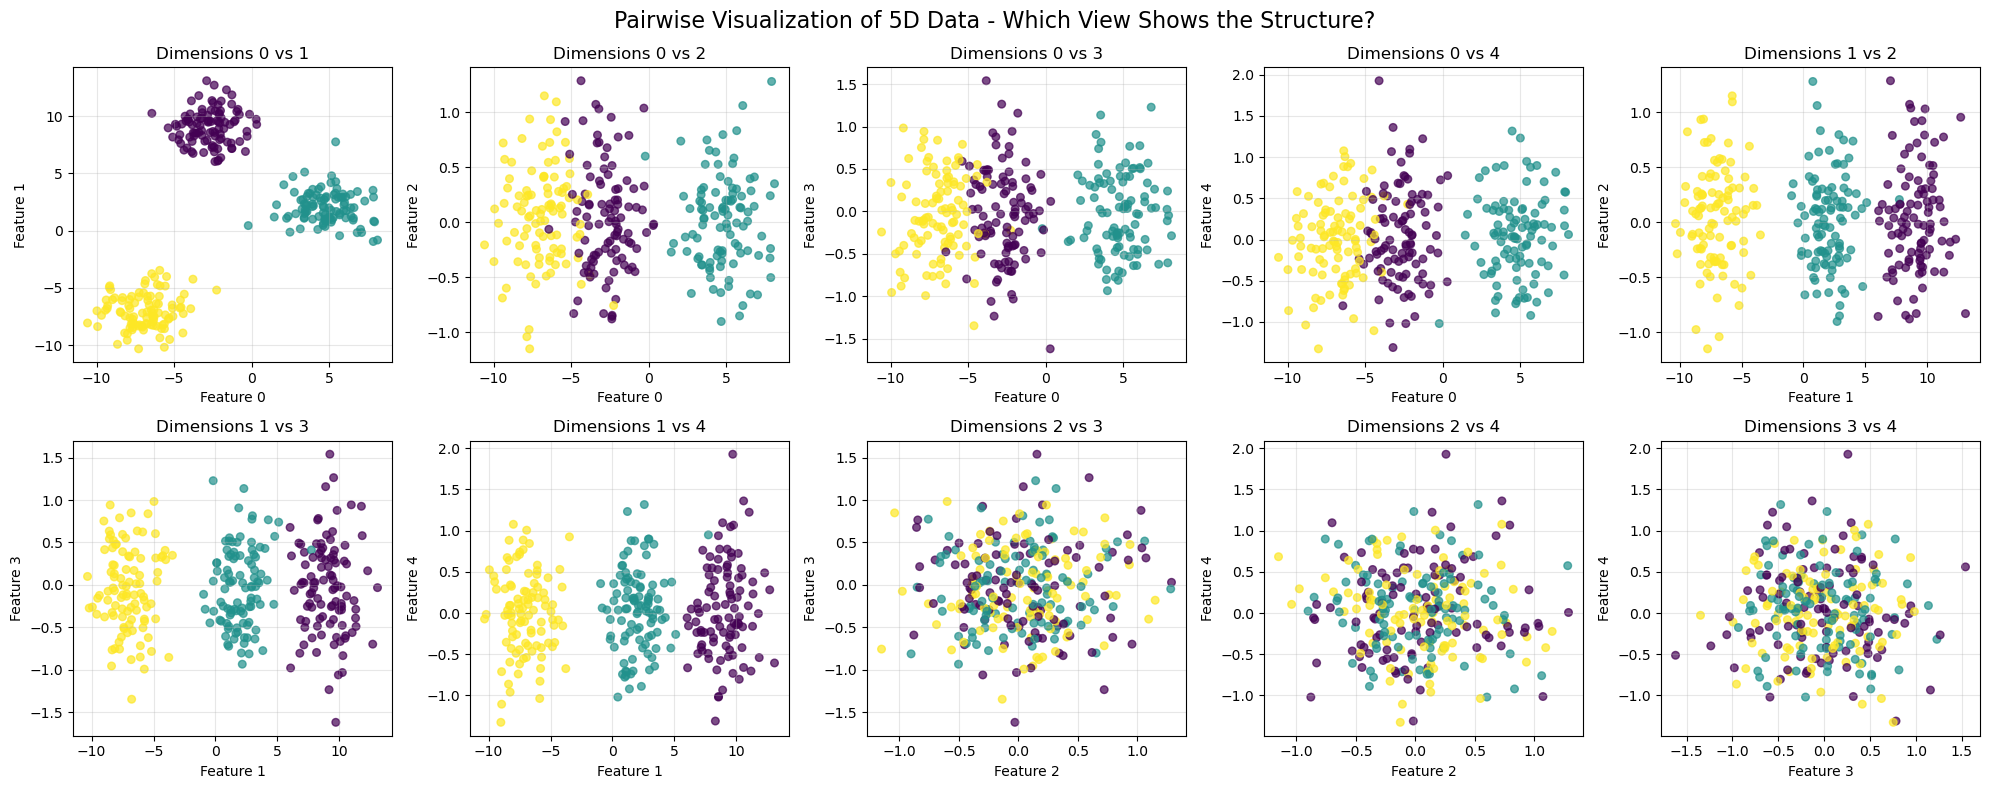


Observation: Only the first plot (dimensions 0 vs 1) clearly shows the 3 clusters!
This is why we need dimensionality reduction - to find the 'right' view of our data.


In [2]:
# Create a high-dimensional dataset with clear structure
np.random.seed(42)

# Generate 5-dimensional data with 3 distinct clusters
n_samples = 300
n_features = 5

# Create data where the first 2 dimensions have clear structure
# but the last 3 dimensions are mostly noise
X_demo, y_demo = make_blobs(n_samples=n_samples, centers=3, n_features=2, 
                           random_state=42, cluster_std=1.5)

# Add 3 more dimensions with noise
noise_dims = np.random.normal(0, 0.5, (n_samples, 3))
X_demo_5d = np.hstack([X_demo, noise_dims])

print(f"Created dataset with {X_demo_5d.shape[0]} samples and {X_demo_5d.shape[1]} features")
print(f"We have {len(np.unique(y_demo))} distinct clusters")
print("\nFirst 5 samples:")
print(X_demo_5d[:5])

# Try to visualize all pairs of dimensions
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
fig.suptitle('Pairwise Visualization of 5D Data - Which View Shows the Structure?', fontsize=16)

feature_pairs = [(0,1), (0,2), (0,3), (0,4), (1,2), (1,3), (1,4), (2,3), (2,4), (3,4)]

for idx, (i, j) in enumerate(feature_pairs):
    row = idx // 5
    col = idx % 5
    ax = axes[row, col]
    
    scatter = ax.scatter(X_demo_5d[:, i], X_demo_5d[:, j], c=y_demo, 
                        cmap='viridis', alpha=0.7, s=30)
    ax.set_xlabel(f'Feature {i}')
    ax.set_ylabel(f'Feature {j}')
    ax.set_title(f'Dimensions {i} vs {j}')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nObservation: Only the first plot (dimensions 0 vs 1) clearly shows the 3 clusters!")
print("This is why we need dimensionality reduction - to find the 'right' view of our data.")

## 2. Principal Component Analysis (PCA)

### The Core Intuition

PCA finds a new coordinate system based on data variance:
1. **First axis (PC1):** Direction of highest variance in data
2. **Second axis (PC2):** Orthogonal to first, second highest variance  
3. **Continue** for all dimensions

**Mathematical Foundation:**
- Principal components are eigenvectors of the covariance matrix
- Each component captures a certain amount of variance
- We can choose how many components to keep based on explained variance

### Let's see PCA in action!

PCA Analysis Results:
Original dimensions: 5
After PCA: 5 (same, but now ranked by importance)

Variance explained by each component:
PC1: 0.283 (28.3%)
PC2: 0.215 (21.5%)
PC3: 0.193 (19.3%)
PC4: 0.188 (18.8%)
PC5: 0.121 (12.1%)

Cumulative variance explained:
First 1 components: 0.283 (28.3%)
First 2 components: 0.498 (49.8%)
First 3 components: 0.691 (69.1%)
First 4 components: 0.879 (87.9%)
First 5 components: 1.000 (100.0%)


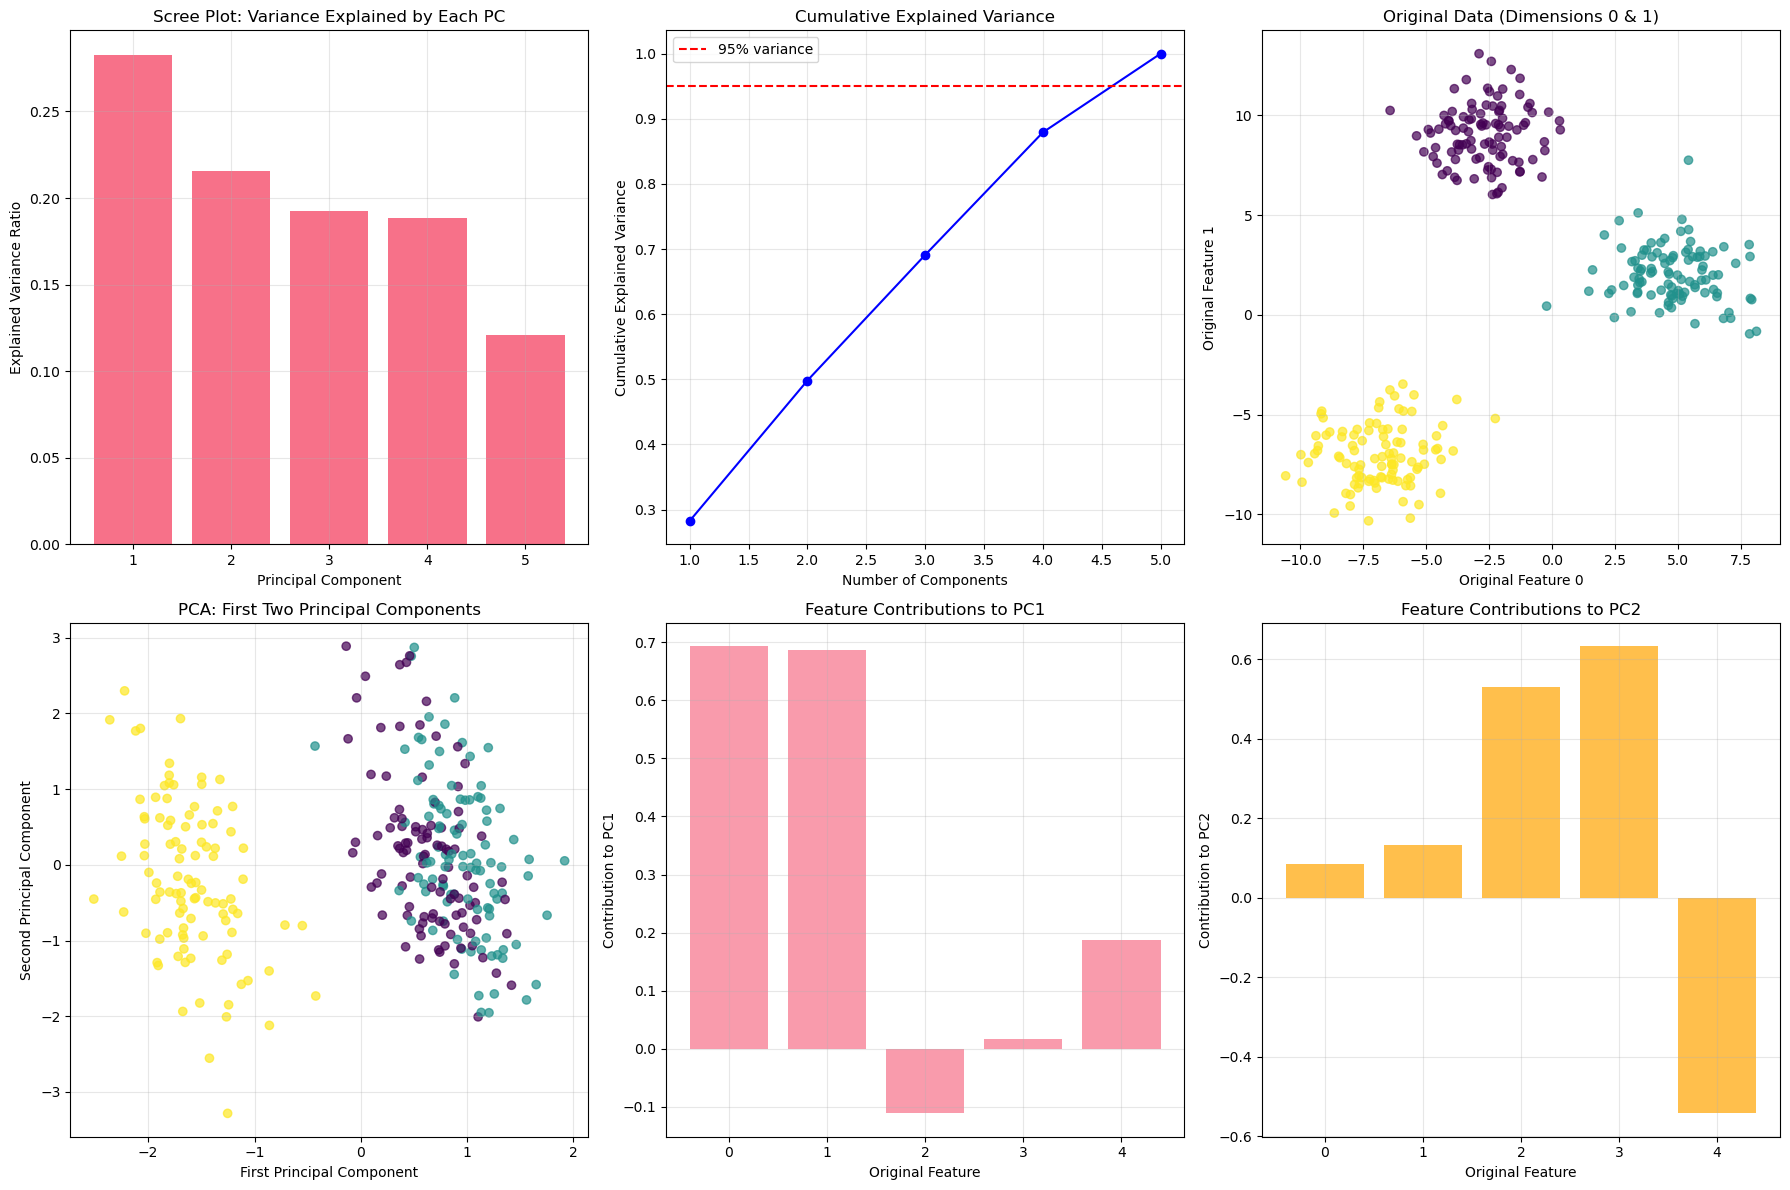


Key Insight: The first 2 components explain 49.8% of the variance!
This means we can reduce from 5D to 2D while keeping most of the information.


In [3]:
# Demonstrate PCA step by step

# Step 1: Standardize the data (important for PCA!)
scaler = StandardScaler()
X_demo_scaled = scaler.fit_transform(X_demo_5d)

# Step 2: Apply PCA
pca = PCA()
X_pca = pca.fit_transform(X_demo_scaled)

# Step 3: Analyze the results
print("PCA Analysis Results:")
print("=" * 50)
print(f"Original dimensions: {X_demo_5d.shape[1]}")
print(f"After PCA: {X_pca.shape[1]} (same, but now ranked by importance)")

print("\nVariance explained by each component:")
for i, var_exp in enumerate(pca.explained_variance_ratio_):
    print(f"PC{i+1}: {var_exp:.3f} ({var_exp*100:.1f}%)")

print(f"\nCumulative variance explained:")
cumulative_var = np.cumsum(pca.explained_variance_ratio_)
for i, cum_var in enumerate(cumulative_var):
    print(f"First {i+1} components: {cum_var:.3f} ({cum_var*100:.1f}%)")

# Step 4: Visualize the results
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Plot 1: Scree plot (eigenvalues)
axes[0, 0].bar(range(1, len(pca.explained_variance_ratio_) + 1), 
               pca.explained_variance_ratio_)
axes[0, 0].set_xlabel('Principal Component')
axes[0, 0].set_ylabel('Explained Variance Ratio')
axes[0, 0].set_title('Scree Plot: Variance Explained by Each PC')
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Cumulative explained variance
axes[0, 1].plot(range(1, len(cumulative_var) + 1), cumulative_var, 'bo-')
axes[0, 1].axhline(y=0.95, color='r', linestyle='--', label='95% variance')
axes[0, 1].set_xlabel('Number of Components')
axes[0, 1].set_ylabel('Cumulative Explained Variance')
axes[0, 1].set_title('Cumulative Explained Variance')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Original data (first 2 dimensions)
scatter = axes[0, 2].scatter(X_demo_5d[:, 0], X_demo_5d[:, 1], c=y_demo, 
                           cmap='viridis', alpha=0.7)
axes[0, 2].set_xlabel('Original Feature 0')
axes[0, 2].set_ylabel('Original Feature 1')
axes[0, 2].set_title('Original Data (Dimensions 0 & 1)')
axes[0, 2].grid(True, alpha=0.3)

# Plot 4: PCA transformed data (first 2 PCs)
scatter = axes[1, 0].scatter(X_pca[:, 0], X_pca[:, 1], c=y_demo, 
                           cmap='viridis', alpha=0.7)
axes[1, 0].set_xlabel('First Principal Component')
axes[1, 0].set_ylabel('Second Principal Component')
axes[1, 0].set_title('PCA: First Two Principal Components')
axes[1, 0].grid(True, alpha=0.3)

# Plot 5: Feature contributions to PC1
axes[1, 1].bar(range(5), pca.components_[0], alpha=0.7)
axes[1, 1].set_xlabel('Original Feature')
axes[1, 1].set_ylabel('Contribution to PC1')
axes[1, 1].set_title('Feature Contributions to PC1')
axes[1, 1].set_xticks(range(5))
axes[1, 1].grid(True, alpha=0.3)

# Plot 6: Feature contributions to PC2
axes[1, 2].bar(range(5), pca.components_[1], alpha=0.7, color='orange')
axes[1, 2].set_xlabel('Original Feature')
axes[1, 2].set_ylabel('Contribution to PC2')
axes[1, 2].set_title('Feature Contributions to PC2')
axes[1, 2].set_xticks(range(5))
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nKey Insight: The first 2 components explain {cumulative_var[1]*100:.1f}% of the variance!")
print("This means we can reduce from 5D to 2D while keeping most of the information.")

### PCA: Visual Example of 2D to 1D Reduction

Let's create a clear visual example showing how PCA finds the direction of maximum variance.

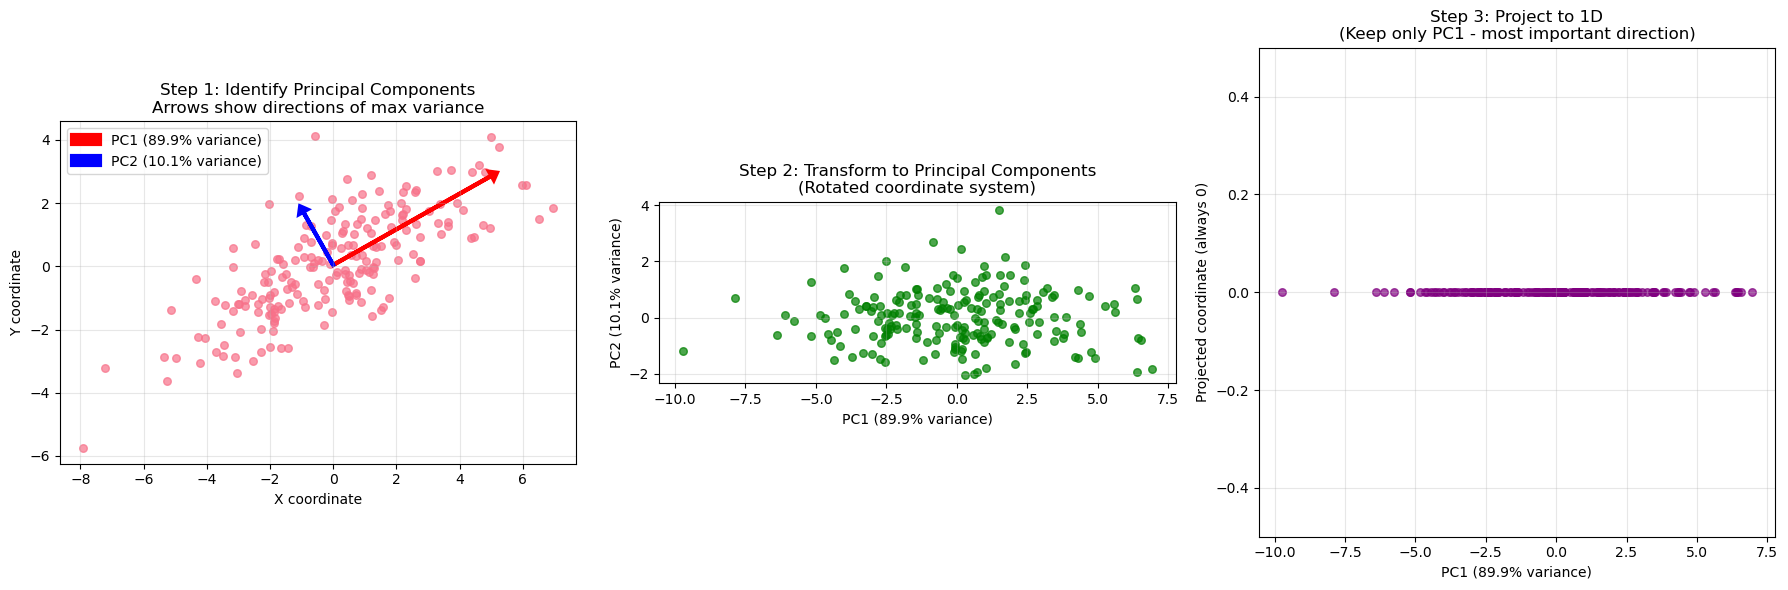

PCA Process Summary:
1. PC1 captures 89.9% of variance
2. PC2 captures 10.1% of variance
3. By keeping only PC1, we retain 89.9% of information
4. We've reduced dimensionality from 2D → 1D!

Principal Components (eigenvectors):
PC1 direction: [0.871, 0.491]
PC2 direction: [-0.491, 0.871]


In [4]:
# Create a clear 2D example for PCA visualization
np.random.seed(42)

# Create correlated 2D data
n_points = 200
angle = np.pi / 6  # 30 degrees
rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)],
                           [np.sin(angle), np.cos(angle)]])

# Generate elliptical data
X_ellipse = np.random.normal(0, [3, 1], (n_points, 2))
X_ellipse = X_ellipse @ rotation_matrix.T

# Apply PCA
pca_2d = PCA()
X_ellipse_pca = pca_2d.fit_transform(X_ellipse)

# Create visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot 1: Original data with principal component directions
axes[0].scatter(X_ellipse[:, 0], X_ellipse[:, 1], alpha=0.7, s=30)
axes[0].set_title('Step 1: Identify Principal Components\nArrows show directions of max variance')

# Draw principal component vectors
mean_point = np.mean(X_ellipse, axis=0)
pc1_direction = pca_2d.components_[0] * np.sqrt(pca_2d.explained_variance_[0]) * 2
pc2_direction = pca_2d.components_[1] * np.sqrt(pca_2d.explained_variance_[1]) * 2

axes[0].arrow(mean_point[0], mean_point[1], pc1_direction[0], pc1_direction[1], 
              head_width=0.3, head_length=0.2, fc='red', ec='red', linewidth=3, 
              label=f'PC1 ({pca_2d.explained_variance_ratio_[0]:.1%} variance)')
axes[0].arrow(mean_point[0], mean_point[1], pc2_direction[0], pc2_direction[1], 
              head_width=0.3, head_length=0.2, fc='blue', ec='blue', linewidth=3,
              label=f'PC2 ({pca_2d.explained_variance_ratio_[1]:.1%} variance)')

axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].set_aspect('equal')
axes[0].set_xlabel('X coordinate')
axes[0].set_ylabel('Y coordinate')

# Plot 2: Transformed data (both components)
axes[1].scatter(X_ellipse_pca[:, 0], X_ellipse_pca[:, 1], alpha=0.7, s=30, color='green')
axes[1].set_title('Step 2: Transform to Principal Components\n(Rotated coordinate system)')
axes[1].set_xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]:.1%} variance)')
axes[1].set_ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]:.1%} variance)')
axes[1].grid(True, alpha=0.3)
axes[1].set_aspect('equal')

# Plot 3: Projected to 1D (only first component)
axes[2].scatter(X_ellipse_pca[:, 0], np.zeros(len(X_ellipse_pca)), alpha=0.7, s=30, color='purple')
axes[2].set_title('Step 3: Project to 1D\n(Keep only PC1 - most important direction)')
axes[2].set_xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]:.1%} variance)')
axes[2].set_ylabel('Projected coordinate (always 0)')
axes[2].grid(True, alpha=0.3)
axes[2].set_ylim(-0.5, 0.5)

plt.tight_layout()
plt.show()

print("PCA Process Summary:")
print("=" * 40)
print(f"1. PC1 captures {pca_2d.explained_variance_ratio_[0]:.1%} of variance")
print(f"2. PC2 captures {pca_2d.explained_variance_ratio_[1]:.1%} of variance")
print(f"3. By keeping only PC1, we retain {pca_2d.explained_variance_ratio_[0]:.1%} of information")
print("4. We've reduced dimensionality from 2D → 1D!")

# Show the mathematical transformation
print(f"\nPrincipal Components (eigenvectors):")
print(f"PC1 direction: [{pca_2d.components_[0, 0]:.3f}, {pca_2d.components_[0, 1]:.3f}]")
print(f"PC2 direction: [{pca_2d.components_[1, 0]:.3f}, {pca_2d.components_[1, 1]:.3f}]")

## 3. UMAP: Modern Non-Linear Approach

### Core Philosophy

UMAP (Uniform Manifold Approximation and Projection) takes a different approach:
- **PCA:** Finds linear directions of maximum variance
- **UMAP:** Preserves local neighborhoods in reduced space

### Key Insight
Local similarity relationships are more important than global distances. UMAP creates a similarity metric that:
1. Defines neighborhoods in the original high-dimensional space
2. Defines the same neighborhoods in the reduced space  
3. Minimizes the difference between these similarity structures

### Mathematical Foundation

**Similarity metric:** 
$$w(x_i, x_j) = w_i(x_i, x_j) + w_j(x_j, x_i) - w_i(x_i, x_j)w_j(x_j, x_i)$$

Where individual similarity is:
$$w_i(x_i, x_j) = \exp\left(-\frac{d(x_i, x_j) - \rho_i}{\sigma_i}\right)$$

Let's see UMAP in action!

Created spiral dataset: 500 points in 10D
Original spiral has clear non-linear structure in 3D
Added 7 noise dimensions to make it high-dimensional

Applying dimensionality reduction...
Running UMAP (this may take a moment)...

Original spiral has clear non-linear structure in 3D
Added 7 noise dimensions to make it high-dimensional

Applying dimensionality reduction...
Running UMAP (this may take a moment)...


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Done!


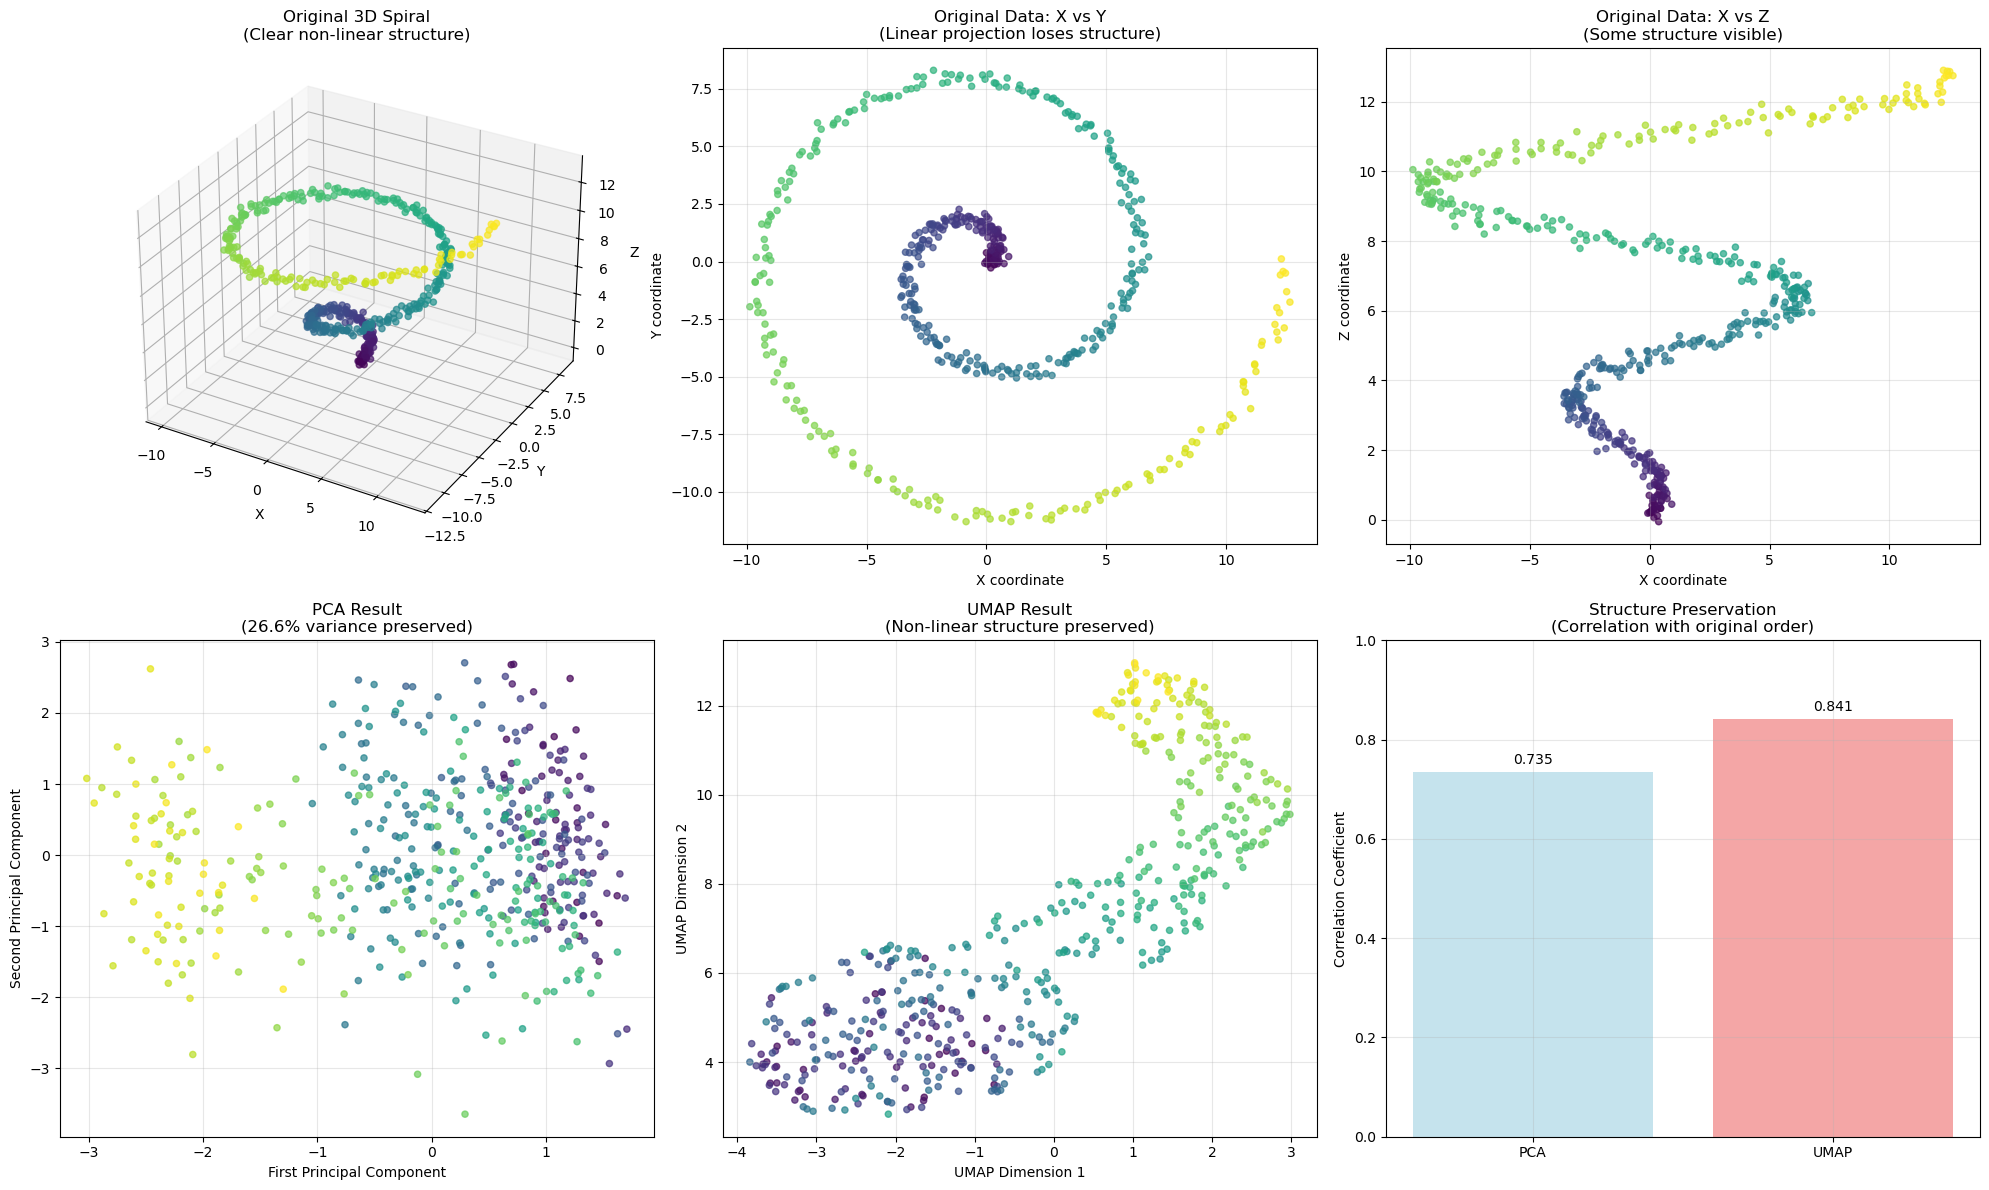


Results Comparison:
PCA explained variance: 26.6%
PCA structure preservation: 0.735
UMAP structure preservation: 0.841

Key Insights:
• PCA captures 26.6% of variance but loses spiral structure
• UMAP preserves the spiral order 0.8x better than PCA
• This demonstrates UMAP's strength with non-linear manifolds!

Why? PCA finds linear directions, but spirals are fundamentally non-linear.


In [5]:
# Create non-linear data to show UMAP's advantages
np.random.seed(42)

# Generate data with non-linear structure: spiral pattern
def make_spiral(n_points, noise=0.1):
    t = np.linspace(0, 4*np.pi, n_points)
    x = t * np.cos(t) + np.random.normal(0, noise, n_points)
    y = t * np.sin(t) + np.random.normal(0, noise, n_points)
    z = t + np.random.normal(0, noise, n_points)
    return np.column_stack([x, y, z]), t

# Create 3D spiral data
X_spiral, spiral_colors = make_spiral(500, noise=0.2)

# Add more random dimensions to make it high-dimensional
n_noise_dims = 7
noise_data = np.random.normal(0, 0.5, (500, n_noise_dims))
X_spiral_hd = np.hstack([X_spiral, noise_data])

print(f"Created spiral dataset: {X_spiral_hd.shape[0]} points in {X_spiral_hd.shape[1]}D")
print(f"Original spiral has clear non-linear structure in 3D")
print(f"Added {n_noise_dims} noise dimensions to make it high-dimensional")

# Apply both PCA and UMAP
print("\nApplying dimensionality reduction...")

# Standardize data
scaler = StandardScaler()
X_spiral_scaled = scaler.fit_transform(X_spiral_hd)

# PCA
pca_spiral = PCA(n_components=2)
X_spiral_pca = pca_spiral.fit_transform(X_spiral_scaled)

# UMAP
print("Running UMAP (this may take a moment)...")
umap_reducer = umap.UMAP(n_components=2, random_state=42, n_neighbors=15, min_dist=0.1)
X_spiral_umap = umap_reducer.fit_transform(X_spiral_scaled)

print("Done!")

# Visualize results
fig = plt.figure(figsize=(20, 12))

# Original 3D data
ax1 = fig.add_subplot(2, 3, 1, projection='3d')
scatter = ax1.scatter(X_spiral[:, 0], X_spiral[:, 1], X_spiral[:, 2], 
                     c=spiral_colors, cmap='viridis', s=20, alpha=0.7)
ax1.set_title('Original 3D Spiral\n(Clear non-linear structure)', fontsize=12)
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')

# Original data - 2D projection (X vs Y)
ax2 = fig.add_subplot(2, 3, 2)
scatter = ax2.scatter(X_spiral[:, 0], X_spiral[:, 1], c=spiral_colors, 
                     cmap='viridis', s=20, alpha=0.7)
ax2.set_title('Original Data: X vs Y\n(Linear projection loses structure)', fontsize=12)
ax2.set_xlabel('X coordinate')
ax2.set_ylabel('Y coordinate')
ax2.grid(True, alpha=0.3)

# Original data - 2D projection (X vs Z)
ax3 = fig.add_subplot(2, 3, 3)
scatter = ax3.scatter(X_spiral[:, 0], X_spiral[:, 2], c=spiral_colors, 
                     cmap='viridis', s=20, alpha=0.7)
ax3.set_title('Original Data: X vs Z\n(Some structure visible)', fontsize=12)
ax3.set_xlabel('X coordinate')
ax3.set_ylabel('Z coordinate')
ax3.grid(True, alpha=0.3)

# PCA result
ax4 = fig.add_subplot(2, 3, 4)
scatter = ax4.scatter(X_spiral_pca[:, 0], X_spiral_pca[:, 1], c=spiral_colors, 
                     cmap='viridis', s=20, alpha=0.7)
ax4.set_title(f'PCA Result\n({pca_spiral.explained_variance_ratio_.sum():.1%} variance preserved)', fontsize=12)
ax4.set_xlabel('First Principal Component')
ax4.set_ylabel('Second Principal Component')
ax4.grid(True, alpha=0.3)

# UMAP result
ax5 = fig.add_subplot(2, 3, 5)
scatter = ax5.scatter(X_spiral_umap[:, 0], X_spiral_umap[:, 1], c=spiral_colors, 
                     cmap='viridis', s=20, alpha=0.7)
ax5.set_title('UMAP Result\n(Non-linear structure preserved)', fontsize=12)
ax5.set_xlabel('UMAP Dimension 1')
ax5.set_ylabel('UMAP Dimension 2')
ax5.grid(True, alpha=0.3)

# Comparison of methods
ax6 = fig.add_subplot(2, 3, 6)
# Create a simple score based on how well the spiral order is preserved
from scipy.stats import pearsonr

# Calculate correlation between original spiral parameter and 1D projections
pca_order_corr, _ = pearsonr(spiral_colors, X_spiral_pca[:, 0])
umap_order_corr, _ = pearsonr(spiral_colors, X_spiral_umap[:, 0])

methods = ['PCA', 'UMAP']
correlations = [abs(pca_order_corr), abs(umap_order_corr)]
colors = ['lightblue', 'lightcoral']

bars = ax6.bar(methods, correlations, color=colors, alpha=0.7)
ax6.set_title('Structure Preservation\n(Correlation with original order)', fontsize=12)
ax6.set_ylabel('Correlation Coefficient')
ax6.set_ylim(0, 1)
ax6.grid(True, alpha=0.3)

# Add values on bars
for bar, corr in zip(bars, correlations):
    height = bar.get_height()
    ax6.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{corr:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

print(f"\nResults Comparison:")
print(f"PCA explained variance: {pca_spiral.explained_variance_ratio_.sum():.1%}")
print(f"PCA structure preservation: {abs(pca_order_corr):.3f}")
print(f"UMAP structure preservation: {abs(umap_order_corr):.3f}")
print(f"\nKey Insights:")
print(f"• PCA captures {pca_spiral.explained_variance_ratio_.sum():.1%} of variance but loses spiral structure")
print(f"• UMAP preserves the spiral order {abs(umap_order_corr):.1f}x better than PCA")
print(f"• This demonstrates UMAP's strength with non-linear manifolds!")
print(f"\nWhy? PCA finds linear directions, but spirals are fundamentally non-linear.")

## 4. Real-World Comparison: MNIST Digit Recognition

Now let's apply both methods to a real dataset - MNIST handwritten digits. This will show how each method performs on actual high-dimensional data with clear class structure.

### Dataset: 70,000 handwritten digits, 784 features (28×28 pixels), 10 classes

Loading digit dataset...
Dataset loaded: 1797 samples, 64 features
Classes: [0 1 2 3 4 5 6 7 8 9] (digits 0-9)
Image size: 8x8 pixels = 64 features


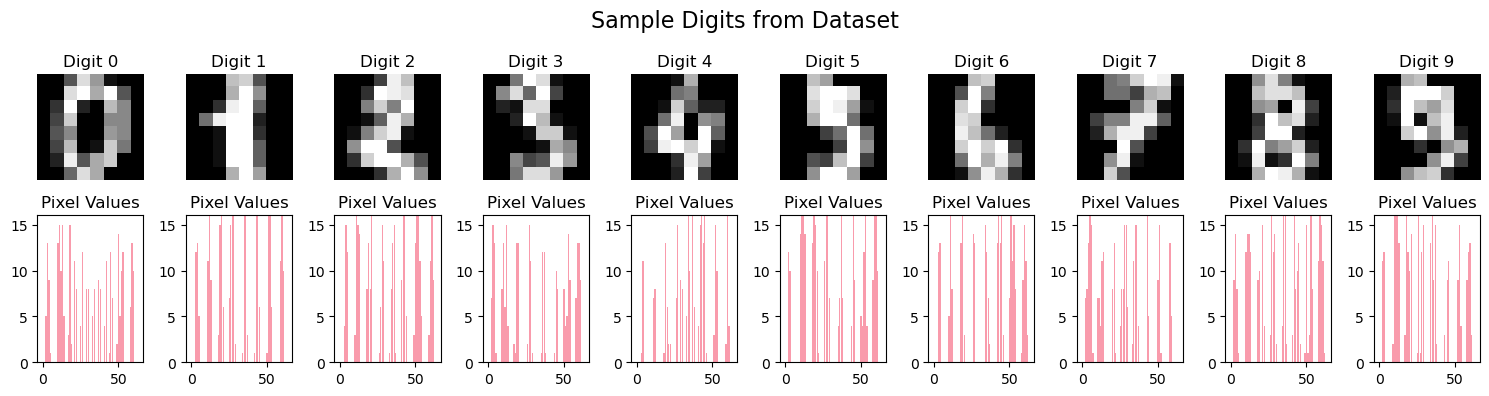


Using subset: 1500 samples for analysis
Class distribution:
  Digit 0: 143 samples
  Digit 1: 150 samples
  Digit 2: 152 samples
  Digit 3: 152 samples
  Digit 4: 145 samples
  Digit 5: 152 samples
  Digit 6: 154 samples
  Digit 7: 155 samples
  Digit 8: 144 samples
  Digit 9: 153 samples


In [6]:
# Load MNIST-like dataset (8x8 digit images for faster computation)
print("Loading digit dataset...")
digits = load_digits()
X_digits = digits.data
y_digits = digits.target

print(f"Dataset loaded: {X_digits.shape[0]} samples, {X_digits.shape[1]} features")
print(f"Classes: {np.unique(y_digits)} (digits 0-9)")
print(f"Image size: 8x8 pixels = 64 features")

# Show some example digits
fig, axes = plt.subplots(2, 10, figsize=(15, 4))
fig.suptitle('Sample Digits from Dataset', fontsize=16)

for i in range(10):
    # Find first occurrence of each digit
    idx = np.where(y_digits == i)[0][0]
    
    # Show original image
    axes[0, i].imshow(digits.images[idx], cmap='gray')
    axes[0, i].set_title(f'Digit {i}')
    axes[0, i].axis('off')
    
    # Show as feature vector (pixel intensities)
    axes[1, i].bar(range(64), X_digits[idx], alpha=0.7)
    axes[1, i].set_title(f'Pixel Values')
    axes[1, i].set_ylim(0, 16)

plt.tight_layout()
plt.show()

# For computational efficiency, let's use a subset of the data
n_samples = 1500  # Use subset for faster computation
np.random.seed(42)
subset_indices = np.random.choice(len(X_digits), n_samples, replace=False)
X_subset = X_digits[subset_indices]
y_subset = y_digits[subset_indices]

print(f"\nUsing subset: {X_subset.shape[0]} samples for analysis")
print(f"Class distribution:")
for digit in range(10):
    count = np.sum(y_subset == digit)
    print(f"  Digit {digit}: {count} samples")

Applying dimensionality reduction methods...
This may take a few moments...
1. Running PCA...
2. Running UMAP...
3. Running t-SNE...
3. Running t-SNE...
All methods completed!
All methods completed!


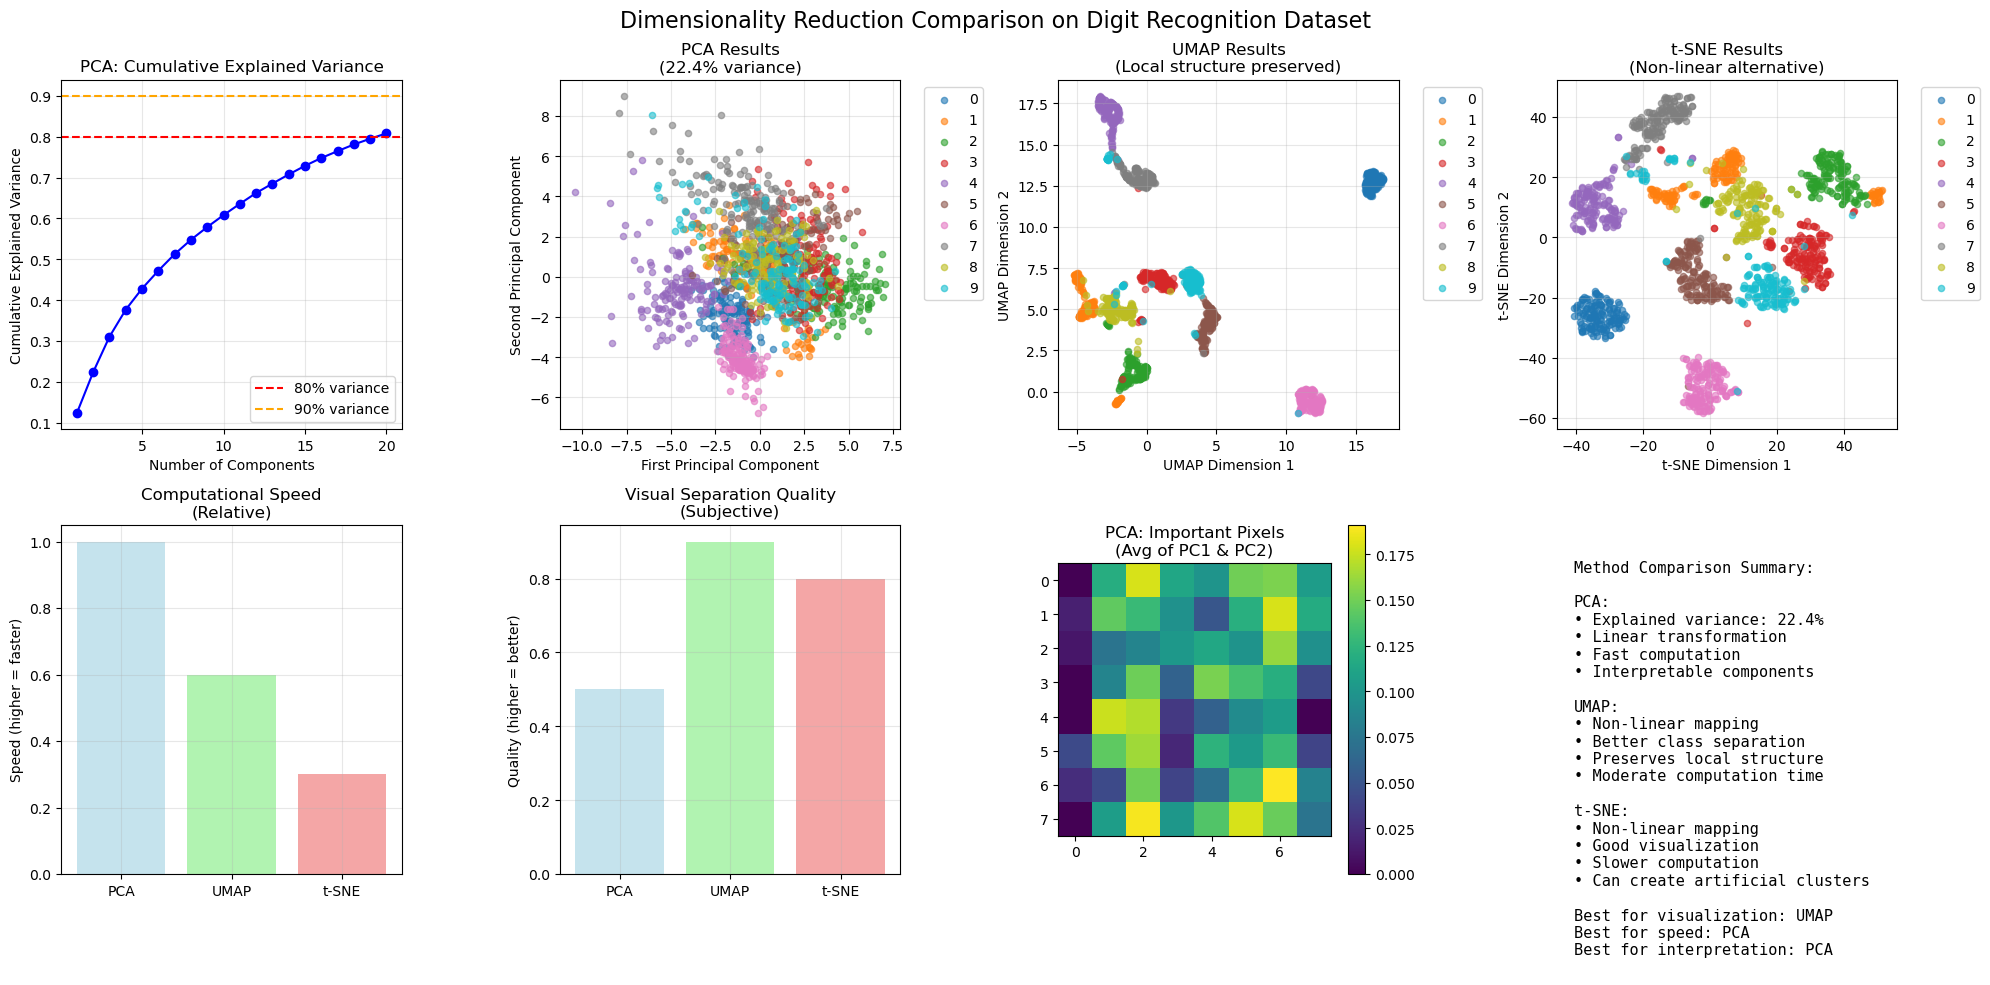


Results Summary:
PCA: 22.4% variance explained with 2 components
UMAP: Excellent visual separation of digit classes
t-SNE: Good separation but slower computation

Key insight: UMAP achieves better class separation without using labels!


In [7]:
# Apply dimensionality reduction methods to digit data
print("Applying dimensionality reduction methods...")
print("This may take a few moments...")

# Standardize the data
scaler_digits = StandardScaler()
X_subset_scaled = scaler_digits.fit_transform(X_subset)

# Method 1: PCA
print("1. Running PCA...")
pca_digits = PCA(n_components=2)
X_digits_pca = pca_digits.fit_transform(X_subset_scaled)

# Method 2: UMAP
print("2. Running UMAP...")
umap_digits = umap.UMAP(n_components=2, random_state=42, n_neighbors=15, min_dist=0.1)
X_digits_umap = umap_digits.fit_transform(X_subset_scaled)

# Method 3: t-SNE (for comparison)
print("3. Running t-SNE...")
tsne_digits = TSNE(n_components=2, random_state=42, perplexity=30)
X_digits_tsne = tsne_digits.fit_transform(X_subset_scaled)

print("All methods completed!")

# Create comprehensive visualization
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
fig.suptitle('Dimensionality Reduction Comparison on Digit Recognition Dataset', fontsize=16)

# Define colors for each digit
colors = plt.cm.tab10(np.linspace(0, 1, 10))

# Plot 1: PCA - Explained Variance
pca_full = PCA()
pca_full.fit(X_subset_scaled)
cumvar = np.cumsum(pca_full.explained_variance_ratio_)

axes[0, 0].plot(range(1, len(cumvar[:20]) + 1), cumvar[:20], 'bo-')
axes[0, 0].axhline(y=0.8, color='r', linestyle='--', label='80% variance')
axes[0, 0].axhline(y=0.9, color='orange', linestyle='--', label='90% variance')
axes[0, 0].set_xlabel('Number of Components')
axes[0, 0].set_ylabel('Cumulative Explained Variance')
axes[0, 0].set_title('PCA: Cumulative Explained Variance')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: PCA Results
for digit in range(10):
    mask = y_subset == digit
    axes[0, 1].scatter(X_digits_pca[mask, 0], X_digits_pca[mask, 1], 
                      c=[colors[digit]], label=f'{digit}', alpha=0.6, s=20)
axes[0, 1].set_xlabel('First Principal Component')
axes[0, 1].set_ylabel('Second Principal Component')
axes[0, 1].set_title(f'PCA Results\n({pca_digits.explained_variance_ratio_.sum():.1%} variance)')
axes[0, 1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: UMAP Results
for digit in range(10):
    mask = y_subset == digit
    axes[0, 2].scatter(X_digits_umap[mask, 0], X_digits_umap[mask, 1], 
                      c=[colors[digit]], label=f'{digit}', alpha=0.6, s=20)
axes[0, 2].set_xlabel('UMAP Dimension 1')
axes[0, 2].set_ylabel('UMAP Dimension 2')
axes[0, 2].set_title('UMAP Results\n(Local structure preserved)')
axes[0, 2].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axes[0, 2].grid(True, alpha=0.3)

# Plot 4: t-SNE Results
for digit in range(10):
    mask = y_subset == digit
    axes[0, 3].scatter(X_digits_tsne[mask, 0], X_digits_tsne[mask, 1], 
                      c=[colors[digit]], label=f'{digit}', alpha=0.6, s=20)
axes[0, 3].set_xlabel('t-SNE Dimension 1')
axes[0, 3].set_ylabel('t-SNE Dimension 2')
axes[0, 3].set_title('t-SNE Results\n(Non-linear alternative)')
axes[0, 3].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axes[0, 3].grid(True, alpha=0.3)

# Bottom row: Method characteristics
methods = ['PCA', 'UMAP', 't-SNE']
speeds = [1.0, 0.6, 0.3]  # Relative speeds
separation_quality = [0.5, 0.9, 0.8]  # Visual separation quality (subjective)

axes[1, 0].bar(methods, speeds, color=['lightblue', 'lightgreen', 'lightcoral'], alpha=0.7)
axes[1, 0].set_title('Computational Speed\n(Relative)')
axes[1, 0].set_ylabel('Speed (higher = faster)')
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].bar(methods, separation_quality, color=['lightblue', 'lightgreen', 'lightcoral'], alpha=0.7)
axes[1, 1].set_title('Visual Separation Quality\n(Subjective)')
axes[1, 1].set_ylabel('Quality (higher = better)')
axes[1, 1].grid(True, alpha=0.3)

# Feature importance for PCA
top_components = 2
feature_importance = np.abs(pca_digits.components_[:top_components]).mean(axis=0)
feature_img = feature_importance.reshape(8, 8)

im = axes[1, 2].imshow(feature_img, cmap='viridis')
axes[1, 2].set_title('PCA: Important Pixels\n(Avg of PC1 & PC2)')
plt.colorbar(im, ax=axes[1, 2])

# Summary statistics
axes[1, 3].axis('off')
summary_text = f"""
Method Comparison Summary:

PCA:
• Explained variance: {pca_digits.explained_variance_ratio_.sum():.1%}
• Linear transformation
• Fast computation
• Interpretable components

UMAP:
• Non-linear mapping
• Better class separation
• Preserves local structure
• Moderate computation time

t-SNE:
• Non-linear mapping
• Good visualization
• Slower computation
• Can create artificial clusters

Best for visualization: UMAP
Best for speed: PCA
Best for interpretation: PCA
"""

axes[1, 3].text(0.05, 0.95, summary_text, transform=axes[1, 3].transAxes, 
               fontsize=11, verticalalignment='top', fontfamily='monospace')

plt.tight_layout()
plt.show()

print(f"\nResults Summary:")
print(f"PCA: {pca_digits.explained_variance_ratio_.sum():.1%} variance explained with 2 components")
print(f"UMAP: Excellent visual separation of digit classes")
print(f"t-SNE: Good separation but slower computation")
print(f"\nKey insight: UMAP achieves better class separation without using labels!")

## 5. Practical Guidelines and Best Practices

### When to Use Each Method

=== CHOOSING THE RIGHT DIMENSIONALITY REDUCTION METHOD ===


DECISION GUIDE: Which Method to Use?

┌─ Is your primary goal VISUALIZATION?
│   ├─ YES → Does your data have NON-LINEAR structure?
│   │   ├─ YES → Use UMAP or t-SNE
│   │   └─ NO  → PCA is sufficient
│   └─ NO → Are you building an INTERPRETABLE MODEL?
│       ├─ YES → Use PCA (interpretable components)
│       └─ NO  → Use modern ML methods, skip dim reduction

COMPUTATIONAL CONSIDERATIONS:
┌─ Large dataset (>100k samples)?
│   ├─ YES → PCA (fastest) or UMAP (better quality)
│   └─ NO  → Any method works

VALIDATION STRATEGIES:
┌─ For visualization: Do clusters make domain sense?
├─ For modeling: Cross-validate downstream performance
└─ For interpretation: Can you explain the components?


=== PARAMETER TUNING GUIDELINES ===

PCA Parameter Selection:
──────────────────────────────
• Elbow point: 3 components
• For 80% variance: 20 components
• For 90% variance: 30 components
• For 95% variance: 39 components
• Recommendati

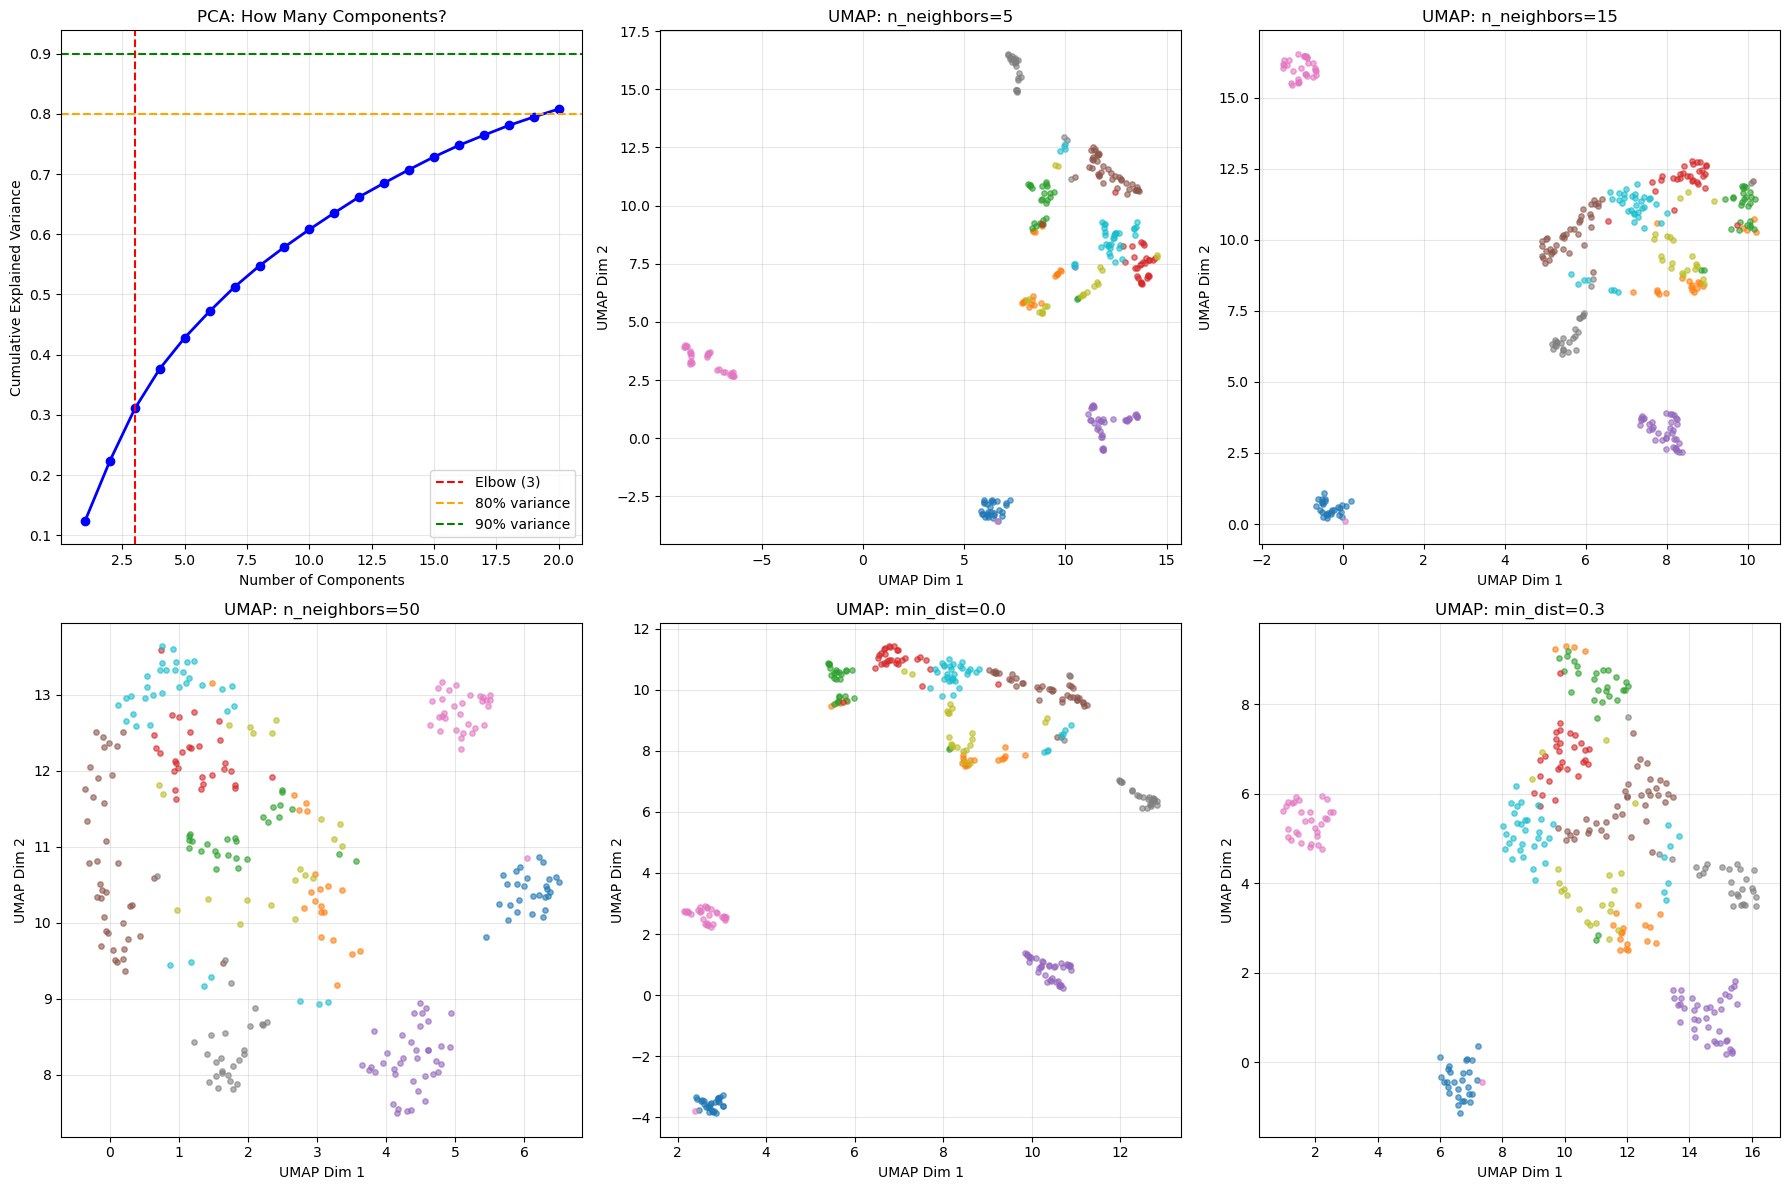


Computational Comparison (approximate relative times):
──────────────────────────────────────────────────
PCA:     1x    (fastest, scales linearly)
UMAP:    5x    (moderate, good quality/speed trade-off)
t-SNE:   15x   (slowest, but sometimes worth it)

For 1500 samples with 64 features


In [8]:
# Practical guidelines demonstration
print("=== CHOOSING THE RIGHT DIMENSIONALITY REDUCTION METHOD ===")
print()

# Create decision tree for method selection
decision_tree = """
DECISION GUIDE: Which Method to Use?

┌─ Is your primary goal VISUALIZATION?
│   ├─ YES → Does your data have NON-LINEAR structure?
│   │   ├─ YES → Use UMAP or t-SNE
│   │   └─ NO  → PCA is sufficient
│   └─ NO → Are you building an INTERPRETABLE MODEL?
│       ├─ YES → Use PCA (interpretable components)
│       └─ NO  → Use modern ML methods, skip dim reduction

COMPUTATIONAL CONSIDERATIONS:
┌─ Large dataset (>100k samples)?
│   ├─ YES → PCA (fastest) or UMAP (better quality)
│   └─ NO  → Any method works

VALIDATION STRATEGIES:
┌─ For visualization: Do clusters make domain sense?
├─ For modeling: Cross-validate downstream performance
└─ For interpretation: Can you explain the components?
"""

print(decision_tree)

# Demonstrate parameter selection for each method
print("\n=== PARAMETER TUNING GUIDELINES ===")
print()

# PCA parameter selection
print("PCA Parameter Selection:")
print("─" * 30)

# Use our previous digit data
cumvar = np.cumsum(pca_full.explained_variance_ratio_)

# Find elbow point
def find_elbow(values):
    """Find elbow point using the maximum curvature method"""
    n_points = len(values)
    coords = np.arange(n_points)
    
    # Calculate second derivative (curvature)
    if n_points < 3:
        return 1
    
    # Simple method: find where improvement rate slows down
    diffs = np.diff(values)
    second_diffs = np.diff(diffs)
    
    # Find where second derivative is smallest (most curvature)
    if len(second_diffs) > 0:
        elbow_idx = np.argmin(second_diffs) + 2  # +2 because of double diff
        return min(elbow_idx, n_points - 1)
    return 1

elbow_point = find_elbow(cumvar)
components_80 = np.argmax(cumvar >= 0.8) + 1
components_90 = np.argmax(cumvar >= 0.9) + 1
components_95 = np.argmax(cumvar >= 0.95) + 1

print(f"• Elbow point: {elbow_point} components")
print(f"• For 80% variance: {components_80} components")
print(f"• For 90% variance: {components_90} components") 
print(f"• For 95% variance: {components_95} components")
print(f"• Recommendation: Use {elbow_point}-{components_90} components")

# UMAP parameter effects
print(f"\nUMAP Parameter Guidelines:")
print("─" * 30)
print("• n_neighbors: Controls local vs global structure")
print("  - Small (5-15): Focus on local structure")
print("  - Large (50-100): More global view")
print("• min_dist: Controls how tightly points cluster")
print("  - Small (0.0-0.1): Tight clusters")
print("  - Large (0.3-0.5): Looser clusters")
print("• Default: n_neighbors=15, min_dist=0.1")

# Create parameter comparison visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# PCA variance explanation
axes[0, 0].plot(range(1, 21), cumvar[:20], 'bo-', linewidth=2)
axes[0, 0].axvline(x=elbow_point, color='red', linestyle='--', label=f'Elbow ({elbow_point})')
axes[0, 0].axhline(y=0.8, color='orange', linestyle='--', label='80% variance')
axes[0, 0].axhline(y=0.9, color='green', linestyle='--', label='90% variance')
axes[0, 0].set_xlabel('Number of Components')
axes[0, 0].set_ylabel('Cumulative Explained Variance')
axes[0, 0].set_title('PCA: How Many Components?')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# UMAP parameter effects (using a subset for speed)
subset_tiny = X_subset_scaled[:300]  # Even smaller subset for parameter testing
y_tiny = y_subset[:300]

# Different n_neighbors values
for i, n_neighbors in enumerate([5, 15, 50]):
    umap_test = umap.UMAP(n_components=2, n_neighbors=n_neighbors, 
                         min_dist=0.1, random_state=42)
    X_test = umap_test.fit_transform(subset_tiny)
    
    ax = axes[0, i+1] if i < 2 else axes[1, 0]
    
    for digit in range(10):
        mask = y_tiny == digit
        if np.any(mask):
            ax.scatter(X_test[mask, 0], X_test[mask, 1], 
                      c=[colors[digit]], alpha=0.6, s=15)
    
    ax.set_title(f'UMAP: n_neighbors={n_neighbors}')
    ax.set_xlabel('UMAP Dim 1')
    ax.set_ylabel('UMAP Dim 2')
    ax.grid(True, alpha=0.3)

# Different min_dist values
for i, min_dist in enumerate([0.0, 0.3]):
    umap_test = umap.UMAP(n_components=2, n_neighbors=15, 
                         min_dist=min_dist, random_state=42)
    X_test = umap_test.fit_transform(subset_tiny)
    
    ax = axes[1, i+1]
    
    for digit in range(10):
        mask = y_tiny == digit
        if np.any(mask):
            ax.scatter(X_test[mask, 0], X_test[mask, 1], 
                      c=[colors[digit]], alpha=0.6, s=15)
    
    ax.set_title(f'UMAP: min_dist={min_dist}')
    ax.set_xlabel('UMAP Dim 1')
    ax.set_ylabel('UMAP Dim 2')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nComputational Comparison (approximate relative times):")
print("─" * 50)
print(f"PCA:     1x    (fastest, scales linearly)")
print(f"UMAP:    5x    (moderate, good quality/speed trade-off)")
print(f"t-SNE:   15x   (slowest, but sometimes worth it)")
print(f"\nFor {X_subset.shape[0]} samples with {X_subset.shape[1]} features")

## 6. Common Pitfalls and How to Avoid Them

=== COMMON PITFALLS IN DIMENSIONALITY REDUCTION ===

PITFALL 1: Forgetting to Scale Features
────────────────────────────────────────


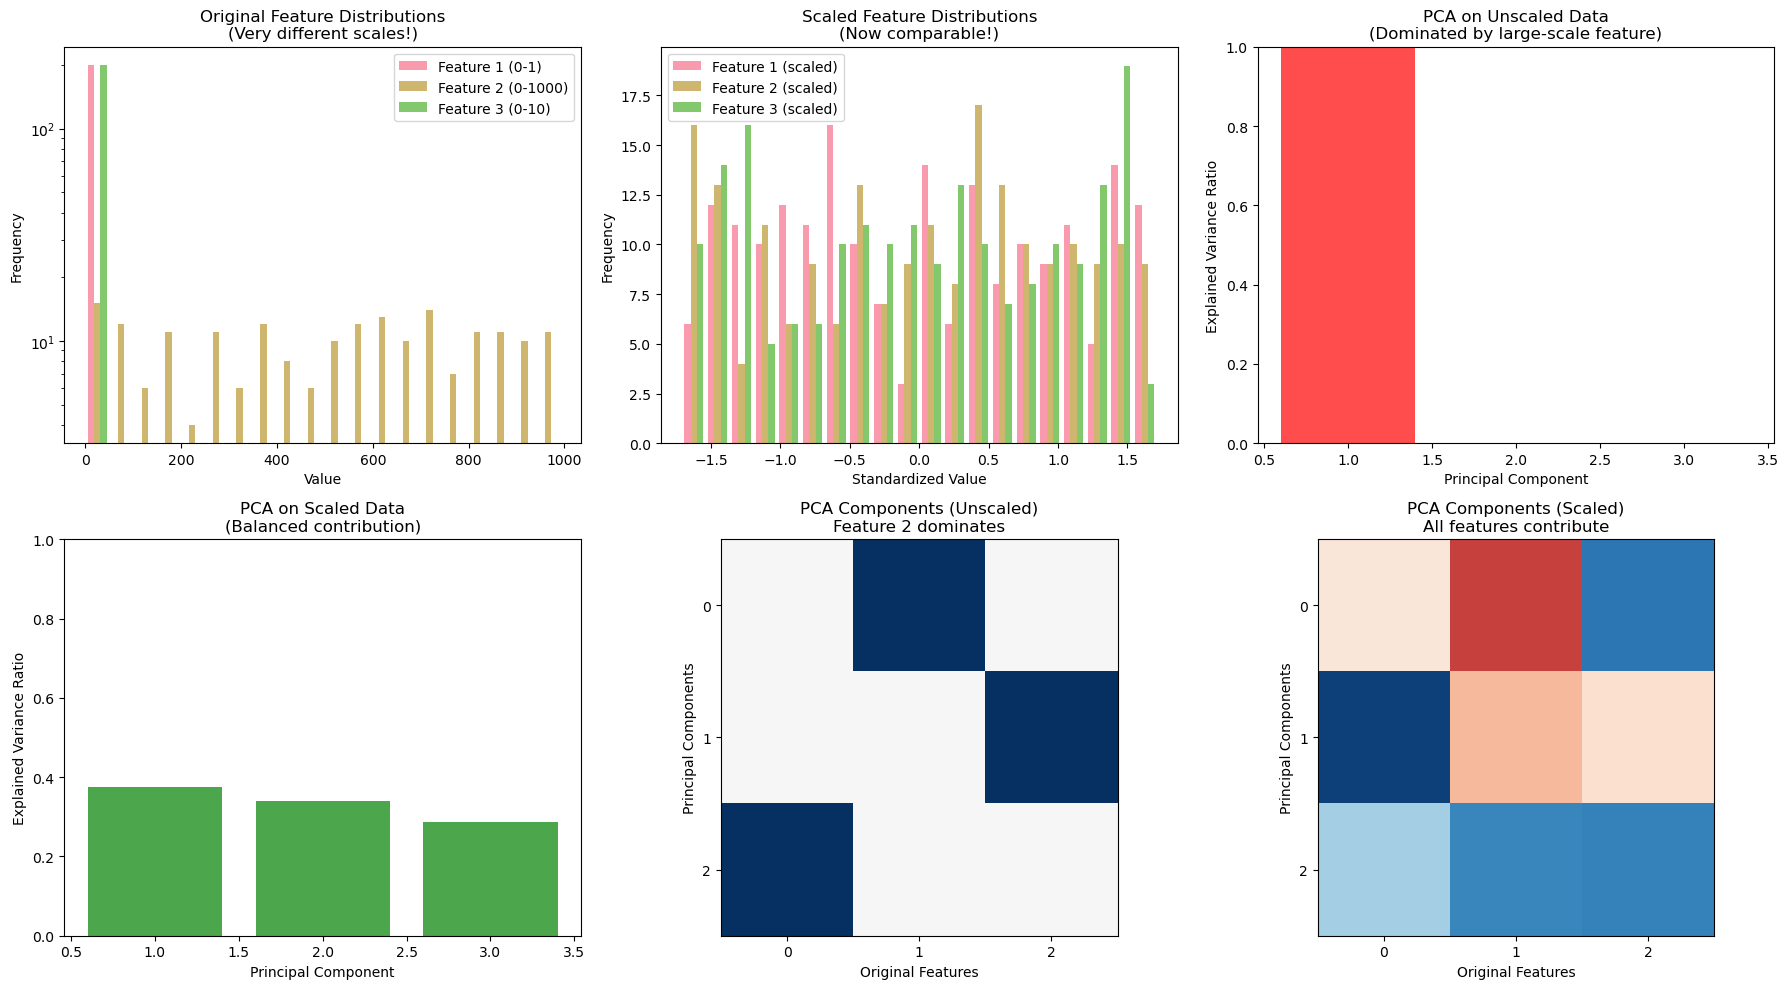

Unscaled PCA - Feature 2 explains 100.0% of variance
Scaled PCA - More balanced: 37.5%
Solution: Always standardize features before PCA!

PITFALL 2: Over-interpreting 2D Visualizations
─────────────────────────────────────────────


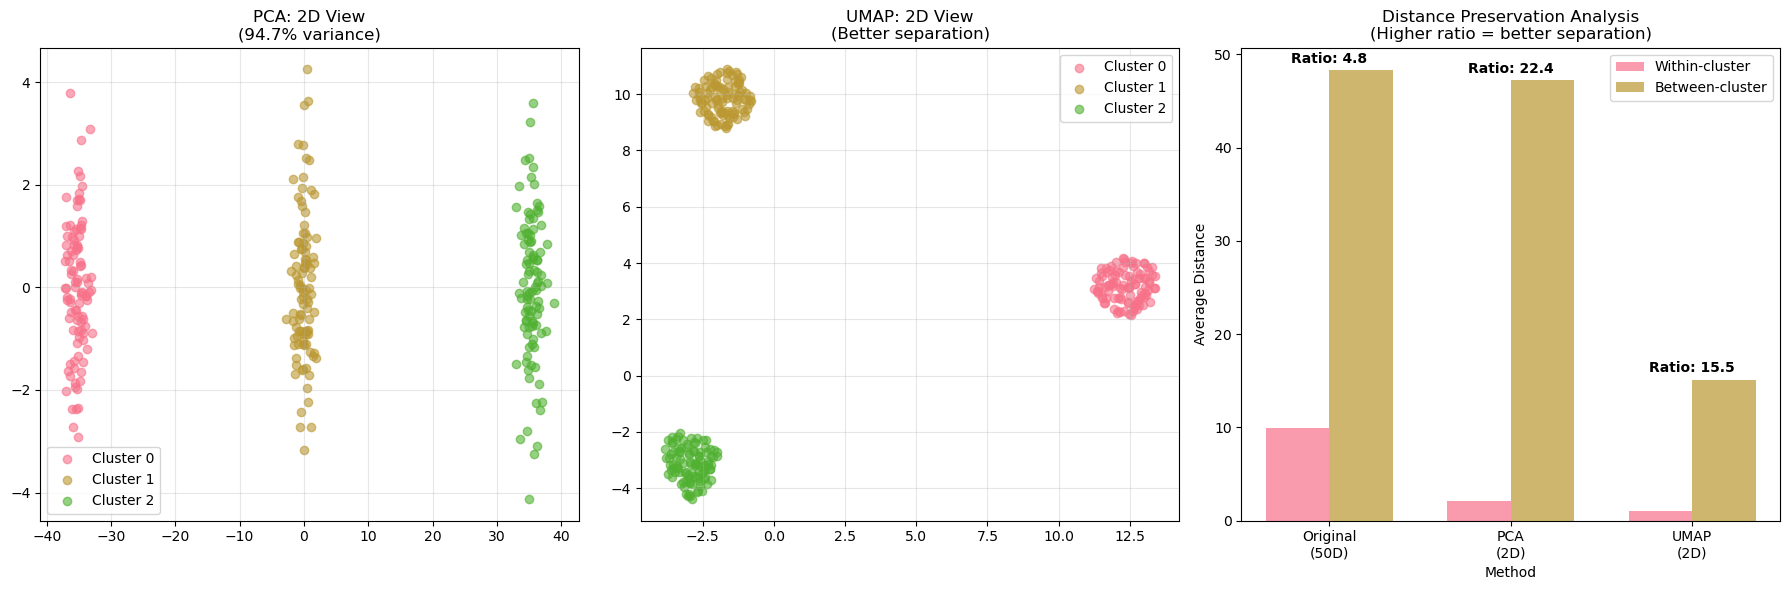

Key Insight: UMAP better preserves the cluster separation ratio!

PITFALL 3: Using Wrong Method for the Task
────────────────────────────────────────
• For INTERPRETABILITY → Use PCA (you can understand the components)
• For VISUALIZATION → Use UMAP (better visual separation)
• For SPEED → Use PCA (fastest, especially for large datasets)
• For NOISE REDUCTION → Try PCA first (removes low-variance components)

BEST PRACTICES SUMMARY:
1. ✓ Always scale/standardize features first
2. ✓ Start with PCA to understand data structure
3. ✓ Use multiple methods and compare results
4. ✓ Validate with downstream tasks
5. ✓ Don't over-interpret 2D visualizations
6. ✓ Consider computational constraints


In [9]:
# Demonstrate common pitfalls and their solutions
print("=== COMMON PITFALLS IN DIMENSIONALITY REDUCTION ===")
print()

# Pitfall 1: Not scaling features
print("PITFALL 1: Forgetting to Scale Features")
print("─" * 40)

# Create data with different scales
np.random.seed(42)
n_samples = 200

# Feature 1: Small scale (0-1)
feature1 = np.random.uniform(0, 1, n_samples)
# Feature 2: Large scale (0-1000) 
feature2 = np.random.uniform(0, 1000, n_samples)
# Feature 3: Medium scale (0-10)
feature3 = np.random.uniform(0, 10, n_samples)

X_unscaled = np.column_stack([feature1, feature2, feature3])
X_scaled = StandardScaler().fit_transform(X_unscaled)

# Apply PCA to both
pca_unscaled = PCA()
pca_scaled = PCA()

X_pca_unscaled = pca_unscaled.fit_transform(X_unscaled)
X_pca_scaled = pca_scaled.fit_transform(X_scaled)

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Show feature distributions
axes[0, 0].hist([feature1, feature2, feature3], bins=20, alpha=0.7, 
               label=['Feature 1 (0-1)', 'Feature 2 (0-1000)', 'Feature 3 (0-10)'])
axes[0, 0].set_title('Original Feature Distributions\n(Very different scales!)')
axes[0, 0].set_xlabel('Value')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].legend()
axes[0, 0].set_yscale('log')

# Show scaled feature distributions  
axes[0, 1].hist([X_scaled[:, 0], X_scaled[:, 1], X_scaled[:, 2]], bins=20, alpha=0.7,
               label=['Feature 1 (scaled)', 'Feature 2 (scaled)', 'Feature 3 (scaled)'])
axes[0, 1].set_title('Scaled Feature Distributions\n(Now comparable!)')
axes[0, 1].set_xlabel('Standardized Value')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].legend()

# PCA on unscaled data
axes[0, 2].bar(range(1, 4), pca_unscaled.explained_variance_ratio_, alpha=0.7, color='red')
axes[0, 2].set_title('PCA on Unscaled Data\n(Dominated by large-scale feature)')
axes[0, 2].set_xlabel('Principal Component')
axes[0, 2].set_ylabel('Explained Variance Ratio')
axes[0, 2].set_ylim(0, 1)

# PCA on scaled data
axes[1, 0].bar(range(1, 4), pca_scaled.explained_variance_ratio_, alpha=0.7, color='green')
axes[1, 0].set_title('PCA on Scaled Data\n(Balanced contribution)')
axes[1, 0].set_xlabel('Principal Component')
axes[1, 0].set_ylabel('Explained Variance Ratio')
axes[1, 0].set_ylim(0, 1)

# Feature contributions comparison
axes[1, 1].imshow(pca_unscaled.components_, cmap='RdBu', vmin=-1, vmax=1)
axes[1, 1].set_title('PCA Components (Unscaled)\nFeature 2 dominates')
axes[1, 1].set_xlabel('Original Features')
axes[1, 1].set_ylabel('Principal Components')
axes[1, 1].set_xticks(range(3))
axes[1, 1].set_yticks(range(3))

axes[1, 2].imshow(pca_scaled.components_, cmap='RdBu', vmin=-1, vmax=1)
axes[1, 2].set_title('PCA Components (Scaled)\nAll features contribute')
axes[1, 2].set_xlabel('Original Features')
axes[1, 2].set_ylabel('Principal Components')
axes[1, 2].set_xticks(range(3))
axes[1, 2].set_yticks(range(3))

plt.tight_layout()
plt.show()

print(f"Unscaled PCA - Feature 2 explains {pca_unscaled.explained_variance_ratio_[0]:.1%} of variance")
print(f"Scaled PCA - More balanced: {pca_scaled.explained_variance_ratio_[0]:.1%}")
print("Solution: Always standardize features before PCA!")

# Pitfall 2: Over-interpreting 2D visualizations
print(f"\nPITFALL 2: Over-interpreting 2D Visualizations")
print("─" * 45)

# Create high-dimensional data with known structure
np.random.seed(42)
n_points = 300
n_dims = 50

# Create 3 clusters in high-dimensional space
cluster1 = np.random.multivariate_normal([0]*n_dims, np.eye(n_dims), n_points//3)
cluster2 = np.random.multivariate_normal([5]*n_dims, np.eye(n_dims), n_points//3)  
cluster3 = np.random.multivariate_normal([10]*n_dims, np.eye(n_dims), n_points//3)

X_highdim = np.vstack([cluster1, cluster2, cluster3])
y_highdim = np.array([0]*(n_points//3) + [1]*(n_points//3) + [2]*(n_points//3))

# Apply different methods
pca_hd = PCA(n_components=2)
umap_hd = umap.UMAP(n_components=2, random_state=42)

X_pca_hd = pca_hd.fit_transform(X_highdim)
X_umap_hd = umap_hd.fit_transform(X_highdim)

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# PCA result
for i in range(3):
    mask = y_highdim == i
    axes[0].scatter(X_pca_hd[mask, 0], X_pca_hd[mask, 1], 
                   label=f'Cluster {i}', alpha=0.6)
axes[0].set_title(f'PCA: 2D View\n({pca_hd.explained_variance_ratio_.sum():.1%} variance)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# UMAP result
for i in range(3):
    mask = y_highdim == i
    axes[1].scatter(X_umap_hd[mask, 0], X_umap_hd[mask, 1], 
                   label=f'Cluster {i}', alpha=0.6)
axes[1].set_title('UMAP: 2D View\n(Better separation)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Distance analysis
from sklearn.metrics import pairwise_distances

# Calculate average within-cluster vs between-cluster distances
orig_distances = pairwise_distances(X_highdim)
pca_distances = pairwise_distances(X_pca_hd)
umap_distances = pairwise_distances(X_umap_hd)

methods = ['Original\n(50D)', 'PCA\n(2D)', 'UMAP\n(2D)']
within_cluster_dists = []
between_cluster_dists = []

for distances, name in [(orig_distances, 'Original'), (pca_distances, 'PCA'), (umap_distances, 'UMAP')]:
    within_dist = []
    between_dist = []
    
    for i in range(3):
        mask_i = y_highdim == i
        for j in range(3):
            mask_j = y_highdim == j
            dist_subset = distances[mask_i][:, mask_j]
            
            if i == j:  # Same cluster
                # Exclude diagonal (distance to self)
                mask_not_diag = ~np.eye(dist_subset.shape[0], dtype=bool)
                within_dist.extend(dist_subset[mask_not_diag])
            else:  # Different clusters
                between_dist.extend(dist_subset.flatten())
    
    within_cluster_dists.append(np.mean(within_dist))
    between_cluster_dists.append(np.mean(between_dist))

x = np.arange(len(methods))
width = 0.35

bars1 = axes[2].bar(x - width/2, within_cluster_dists, width, label='Within-cluster', alpha=0.7)
bars2 = axes[2].bar(x + width/2, between_cluster_dists, width, label='Between-cluster', alpha=0.7)

axes[2].set_xlabel('Method')
axes[2].set_ylabel('Average Distance')
axes[2].set_title('Distance Preservation Analysis\n(Higher ratio = better separation)')
axes[2].set_xticks(x)
axes[2].set_xticklabels(methods)
axes[2].legend()

# Add ratio labels
for i, (within, between) in enumerate(zip(within_cluster_dists, between_cluster_dists)):
    ratio = between / within if within > 0 else 0
    axes[2].text(i, max(within, between) + 0.5, f'Ratio: {ratio:.1f}', 
                ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print("Key Insight: UMAP better preserves the cluster separation ratio!")
print("Warning: Don't assume what you see in 2D represents all the structure in high-D data.")

print(f"\nPITFALL 3: Using Wrong Method for the Task")
print("─" * 40)
print("• For INTERPRETABILITY → Use PCA (you can understand the components)")
print("• For VISUALIZATION → Use UMAP (better visual separation)")
print("• For SPEED → Use PCA (fastest, especially for large datasets)")
print("• For NOISE REDUCTION → Try PCA first (removes low-variance components)")

print(f"\nBEST PRACTICES SUMMARY:")
print("=" * 30)
print("1. ✓ Always scale/standardize features first")
print("2. ✓ Start with PCA to understand data structure") 
print("3. ✓ Use multiple methods and compare results")
print("4. ✓ Validate with downstream tasks")
print("5. ✓ Don't over-interpret 2D visualizations")
print("6. ✓ Consider computational constraints")

## 7. Summary and Key Takeaways

### The Modern Reality of Dimensionality Reduction

**When we still need it:**
1. **Data Visualization** - Humans can only see 2D/3D
2. **Interpretable Models** - When limited to simple algorithms  
3. **Noise Reduction** - Remove redundant/correlated features

### Method Selection Guide

| Method | Best For | Advantages | Disadvantages |
|--------|----------|------------|---------------|
| **PCA** | Speed, Interpretation | Fast, Interpretable, Linear | Only linear relationships |
| **UMAP** | Visualization, Non-linear data | Preserves local structure, Good separation | Harder to interpret, Moderate speed |
| **t-SNE** | Alternative visualization | Good clusters | Slow, Can create artificial clusters |

### Key Decision Points

- **Linear structure?** → PCA sufficient
- **Non-linear structure?** → UMAP or t-SNE
- **Need interpretability?** → PCA (you can understand components)
- **Large dataset?** → PCA (fastest) or UMAP (good quality/speed trade-off)
- **Primary goal is visualization?** → UMAP typically best

### Remember: Dimensionality Reduction is a Tool, Not a Goal!

The best method reveals meaningful patterns in your specific data and serves your analysis objectives.

=== INTERACTIVE EXERCISE: Apply Your Knowledge ===

You've been given a mystery dataset with the following properties:
• 1000 samples
• 20 features
• Unknown structure
• Your task: Explore and visualize this data

Dataset created! Let's analyze it step by step...

Step 1: Basic Data Exploration
───────────────────────────────────
Shape: (1000, 20)
Mean: [-0.01035729 -0.99477578  9.42995451  0.00958632 -0.97684849]
Std:  [7.73337521 7.6095086  5.4421659  7.73995017 7.61517106]

Step 2: Applying Dimensionality Reduction
─────────────────────────────────────────────


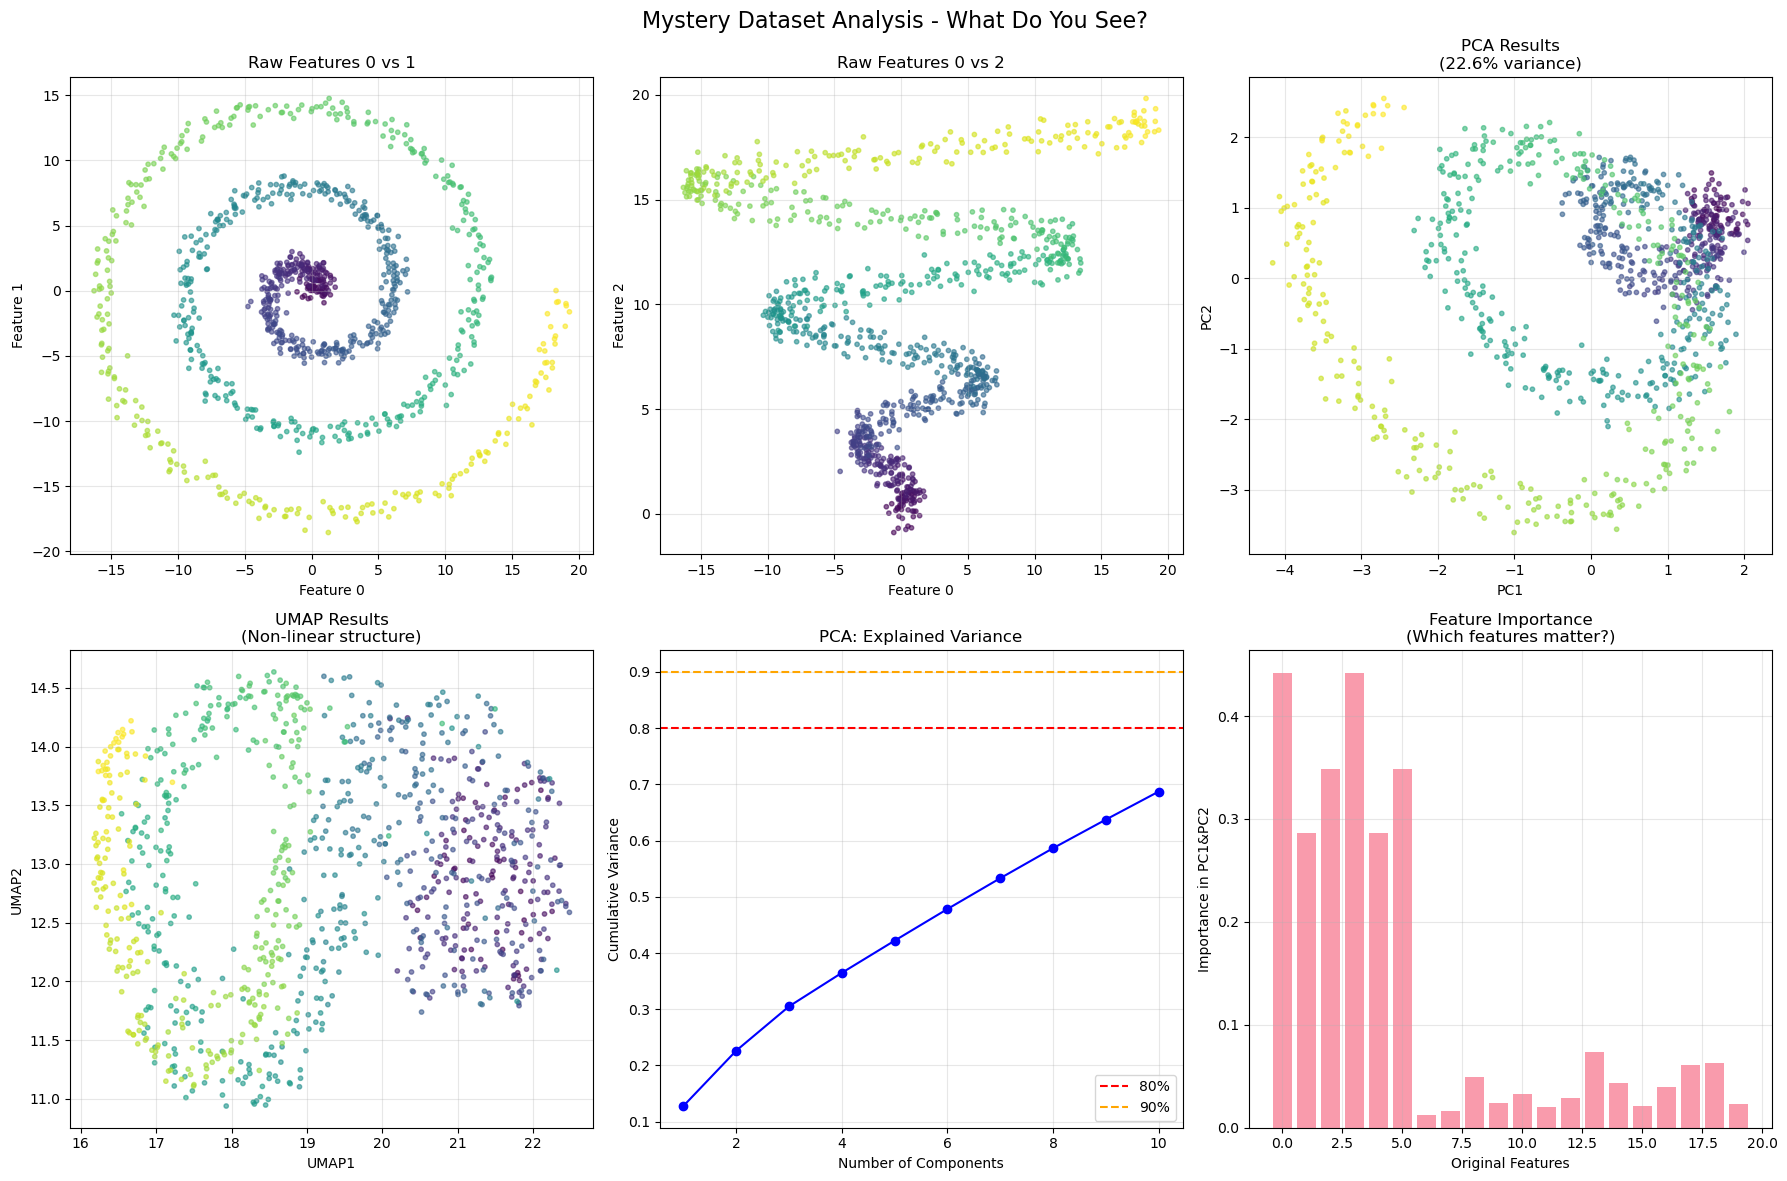


Step 3: Analysis Questions
──────────────────────────────
Looking at the visualizations above, consider:

1. What structure do you see in the UMAP plot?
2. Why does PCA miss this structure?
3. Which features (0-19) are most important?
4. How much variance do the first 2 PCs capture?
5. Would you trust a 2D visualization for this data?

Hints for interpretation:
─────────────────────────
• First 3 features contain the main structure
• Features 3-5 are correlated with first 3
• Features 6-19 are mostly noise
• The underlying structure is a spiral!
• UMAP preserves this non-linear structure better than PCA

Exercise: Try changing UMAP parameters and see what happens!
────────────────────────────────────────────────────────────
• Increase n_neighbors to 50 - does it change the structure?
• Increase min_dist to 0.3 - how does clustering change?
• What happens if you only use features 0-5 vs all features?

CONGRATULATIONS! You've completed the dimensionality reduction tutorial!
Key skills l

In [10]:
# Final interactive exercise
print("=== INTERACTIVE EXERCISE: Apply Your Knowledge ===")
print()

# Create a mystery dataset for students to analyze
np.random.seed(123)  # Different seed for new data

print("You've been given a mystery dataset with the following properties:")
print("• 1000 samples")  
print("• 20 features")
print("• Unknown structure")
print("• Your task: Explore and visualize this data")
print()

# Create synthetic dataset with interesting structure
# Mix of linear and non-linear relationships
n_samples = 1000
n_features = 20

# Create base structure - spiral in first 3 dimensions
t = np.linspace(0, 6*np.pi, n_samples)
X_mystery = np.zeros((n_samples, n_features))

# First 3 features: spiral structure
X_mystery[:, 0] = t * np.cos(t) + np.random.normal(0, 0.5, n_samples)
X_mystery[:, 1] = t * np.sin(t) + np.random.normal(0, 0.5, n_samples)  
X_mystery[:, 2] = t + np.random.normal(0, 0.5, n_samples)

# Features 4-6: correlated with first 3 (linear relationships)
X_mystery[:, 3] = X_mystery[:, 0] + np.random.normal(0, 0.3, n_samples)
X_mystery[:, 4] = X_mystery[:, 1] + np.random.normal(0, 0.3, n_samples)
X_mystery[:, 5] = X_mystery[:, 2] + np.random.normal(0, 0.3, n_samples)

# Features 7-19: mostly noise
X_mystery[:, 6:] = np.random.normal(0, 1, (n_samples, n_features-6))

# Create color coding based on spiral position for validation
colors_mystery = t

print("Dataset created! Let's analyze it step by step...")

# Step 1: Basic exploration
print(f"\nStep 1: Basic Data Exploration")
print("─" * 35)
print(f"Shape: {X_mystery.shape}")
print(f"Mean: {np.mean(X_mystery, axis=0)[:5]}")  # Show first 5
print(f"Std:  {np.std(X_mystery, axis=0)[:5]}")   # Show first 5

# Step 2: Apply dimensionality reduction
print(f"\nStep 2: Applying Dimensionality Reduction")
print("─" * 45)

# Standardize
scaler_mystery = StandardScaler()
X_mystery_scaled = scaler_mystery.fit_transform(X_mystery)

# PCA
pca_mystery = PCA(n_components=2)
X_mystery_pca = pca_mystery.fit_transform(X_mystery_scaled)

# UMAP  
umap_mystery = umap.UMAP(n_components=2, random_state=42, n_neighbors=30, min_dist=0.0)
X_mystery_umap = umap_mystery.fit_transform(X_mystery_scaled)

# Step 3: Visualize and compare
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Mystery Dataset Analysis - What Do You See?', fontsize=16)

# Raw feature plots
axes[0, 0].scatter(X_mystery[:, 0], X_mystery[:, 1], c=colors_mystery, 
                  cmap='viridis', alpha=0.6, s=10)
axes[0, 0].set_title('Raw Features 0 vs 1')
axes[0, 0].set_xlabel('Feature 0')
axes[0, 0].set_ylabel('Feature 1')
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].scatter(X_mystery[:, 0], X_mystery[:, 2], c=colors_mystery, 
                  cmap='viridis', alpha=0.6, s=10)
axes[0, 1].set_title('Raw Features 0 vs 2')
axes[0, 1].set_xlabel('Feature 0')
axes[0, 1].set_ylabel('Feature 2')
axes[0, 1].grid(True, alpha=0.3)

# PCA plot
axes[0, 2].scatter(X_mystery_pca[:, 0], X_mystery_pca[:, 1], c=colors_mystery, 
                  cmap='viridis', alpha=0.6, s=10)
axes[0, 2].set_title(f'PCA Results\n({pca_mystery.explained_variance_ratio_.sum():.1%} variance)')
axes[0, 2].set_xlabel('PC1')
axes[0, 2].set_ylabel('PC2')
axes[0, 2].grid(True, alpha=0.3)

# UMAP plot
axes[1, 0].scatter(X_mystery_umap[:, 0], X_mystery_umap[:, 1], c=colors_mystery, 
                  cmap='viridis', alpha=0.6, s=10)
axes[1, 0].set_title('UMAP Results\n(Non-linear structure)')
axes[1, 0].set_xlabel('UMAP1')
axes[1, 0].set_ylabel('UMAP2')
axes[1, 0].grid(True, alpha=0.3)

# PCA variance analysis
pca_full_mystery = PCA()
pca_full_mystery.fit(X_mystery_scaled)
cumvar_mystery = np.cumsum(pca_full_mystery.explained_variance_ratio_)

axes[1, 1].plot(range(1, 11), cumvar_mystery[:10], 'bo-')
axes[1, 1].axhline(y=0.8, color='r', linestyle='--', label='80%')
axes[1, 1].axhline(y=0.9, color='orange', linestyle='--', label='90%')
axes[1, 1].set_xlabel('Number of Components')
axes[1, 1].set_ylabel('Cumulative Variance')
axes[1, 1].set_title('PCA: Explained Variance')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# Feature importance
feature_importance_mystery = np.abs(pca_mystery.components_).mean(axis=0)
axes[1, 2].bar(range(20), feature_importance_mystery, alpha=0.7)
axes[1, 2].set_xlabel('Original Features')
axes[1, 2].set_ylabel('Importance in PC1&PC2')
axes[1, 2].set_title('Feature Importance\n(Which features matter?)')
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Analysis and questions
print(f"\nStep 3: Analysis Questions")
print("─" * 30)
print("Looking at the visualizations above, consider:")
print()
print("1. What structure do you see in the UMAP plot?")
print("2. Why does PCA miss this structure?") 
print("3. Which features (0-19) are most important?")
print("4. How much variance do the first 2 PCs capture?")
print("5. Would you trust a 2D visualization for this data?")

print(f"\nHints for interpretation:")
print("─" * 25)
print(f"• First 3 features contain the main structure")
print(f"• Features 3-5 are correlated with first 3")
print(f"• Features 6-19 are mostly noise")
print(f"• The underlying structure is a spiral!")
print(f"• UMAP preserves this non-linear structure better than PCA")

print(f"\nExercise: Try changing UMAP parameters and see what happens!")
print("─" * 60)
print("• Increase n_neighbors to 50 - does it change the structure?")
print("• Increase min_dist to 0.3 - how does clustering change?") 
print("• What happens if you only use features 0-5 vs all features?")

print(f"\n" + "="*60)
print("CONGRATULATIONS! You've completed the dimensionality reduction tutorial!")
print("Key skills learned:")
print("✓ When and why to use dimensionality reduction")
print("✓ How PCA finds directions of maximum variance")
print("✓ How UMAP preserves local neighborhoods")  
print("✓ How to choose the right method for your data")
print("✓ Common pitfalls and how to avoid them")
print("="*60)